# N starvation 

## Which N sources allow MED4 to grow

check out Escher visualization https://escher.readthedocs.io/en/latest/getting_started.html

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns
import itertools
from matplotlib.colors import LogNorm, Normalize


In [6]:
import subprocess
import time
import os

In [7]:
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import production_envelope


In [8]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)

In [9]:
RNA_dpath =os.path.join('data', 'RNASEQ') 
os.listdir(RNA_dpath)

['MED4_DE_DESEQ_results.csv',
 'MED4_DE_genes_DESEQ_wKEGG.csv',
 'MED4_counts_combined.txt',
 'MED4_PMM2locus.csv']

In [10]:
pmm_df = pd.read_csv(os.path.join(RNA_dpath, 'MED4_PMM2locus.csv'), names=['gene_id', 'pmm'])


In [11]:
deseq_df = pd.read_csv(os.path.join(RNA_dpath, 'MED4_DE_genes_DESEQ_wKEGG.csv'))


In [12]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

In [13]:
# values from Ofaim at el.

PARAMETER_VALUES = [#"Name",     "Reaction ID",          "Lower bound", "UpperBound"
                   ["HCO3",      "HCO3EXcar",            -8,            0],
                   #["Nitrogen",  "AmmoniaEX",            -0.56,         0],
                   #["Phosphate", "FAKEOrthophosphateEX", -0.1,          0],
                   ["Light",     "LightEX",              -150,          0]]
CO2MAX = 0.82

# Block fake reactions
FAKE_TRANSPORT = ["AminosugarsOUT", "FAKEAAOUT", "FAKEABPOUT", "FAKEacpTRANS", "FAKEApoacpTRANS", "FAKEThioredoxinTRANS", 
                  "FreefattyacidsOUT", "7NMeth7carbOUT", "ArtificialproteinOUT", "FADOUT", "LipoylproteinTRANS", "MenaquinoneOUT", 
                  "NicotinateOUT", "THFpolyglutOUT", "Thiamin_dpOUT"]


In [14]:
def get_elements(rid):
    r = model.reactions.get_by_id(rid)
    m = r.reactants[0]    
    elements = m.elements.copy()
    
    res = {
        'reaction' : rid,
        'metabolite' : m.name,
        'N' : 'N' in elements,
        'C' : 'C' in elements,
        
    }
    return res

# Import model and manipulate based on Ofaim at el

In [15]:
import os
model_dpath = os.path.join('..', 'Model_files')
model_fname = 'iSO595v7.xml'
model_fpath = os.path.join(model_dpath, model_fname)


In [16]:
model = cobra.io.read_sbml_model(model_fpath)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-13


In [17]:
# manipulations copied from Ofaim at el.

remove_blocked = False

# Block H2S
model.reactions.H2SEX.lower_bound = 0

# Block fake transports
for rid in FAKE_TRANSPORT:
    model.reactions.get_by_id(rid).bounds = (0,0)

# Remove blocked reactions
if remove_blocked:
    blocked = cobra.flux_analysis.find_blocked_reactions(model, open_exchanges = True)
    print('blocked', len(blocked), blocked)
    model.remove_reactions([model.reactions.get_by_id(r_id) for r_id in blocked])

# Block maximum CO2 production
model.reactions.CO2EX.bounds = (0, CO2MAX)

for i, row in enumerate(PARAMETER_VALUES):
    # Row: Name, Reaction ID, lower bound, upper bound
    key = row[0]
    reaction_id = row[1]
    lower_bound = row[2]
    upper_bound = row[3]
    r = model.reactions.get_by_id(reaction_id)
    # Fix flux
    r.bounds = (lower_bound, upper_bound)

In [18]:
exchange_ids = [r.id for r in model.exchanges] # + ["R00024"]

In [19]:
print('reactions', len(model.reactions))
print('metabolites', len(model.metabolites))
print('genes', len(model.genes))

reactions 994
metabolites 802
genes 595


In [20]:
model

Name,COBRAModel
Memory address,0x07f911edecf10
Number of metabolites,802
Number of reactions,994
Number of groups,55
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"Cytoplasm, Extracellular, unknownCompartment2, Periplasm, unknownCompartment5"


In [21]:
model.reactions.get_by_id('BIOMASS')

Reaction identifier,BIOMASS
Name,Biomass formation
Memory address,0x7f911ea4bb20
Stoichiometry,104.0 ATP[c] + 0.0324116276714271 BioPool[c] + 0.0268408791654006 Bmineral[c] + 0.0559910868023904 Cell_wall[c] + 0.00111921401802897 Free_nucleic_acids[c] + 104.0 H2O[c] + 0.649245416793275... 104.0 ATP + 0.0324116276714271 BioPool + 0.0268408791654006 Trace metals and minerals + 0.0559910868023904 Cell wall Biomass precursor + 0.00111921401802897 Free nucleic acids + 104.0 H2O +...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [23]:
fpath = os.path.join('data','PRO_N_sources.xlsx')
df_growing = pd.read_excel(fpath, sheet_name='uptake')
n_exchange_df = pd.read_excel(fpath, sheet_name='secretion')


# Knockout genes - to find genes required for uptake/secretion

### Partition genes and reactions to essential and non-essential

In [50]:
# open all potential mediums and run gene knockout to see what is blocking growth when all N sources are available 
with model:
    medium = model.medium
    medium["AmmoniaEX"] = 0.0
    for i in df_growing.uptake:
        medium[i] = 1000.0
    model.medium = medium
    model.reactions.BIOMASS.lower_bound = 1e-5
    solution = model.optimize()
    print(model.summary())
    essential_gene_df = single_gene_deletion(model, processes=10)
    print('done genes')
    essential_reaction_df = single_reaction_deletion(model, processes=10)



Objective
1.0 BIOMASS = 1.318332141786151

Uptake
------
         Metabolite             Reaction      Flux  C-Number C-Flux
         Cadmium[e]            CadmiumEX 6.363E-05         0  0.00%
  Calcium_cation[e]            CalciumEX   0.03529         0  0.00%
    Chloride_ion[e]           ChlorideEX    0.3136         0  0.00%
      Cobalt_ion[e]             CobaltEX  0.002046         0  0.00%
          Copper[e]             CopperEX 0.0001151         0  0.00%
  Orthophosphate[e] FAKEOrthophosphateEX     0.479         0  0.00%
     Glutathione[e]        GlutathioneEX    0.6745         0  0.00%
       Guanosine[e]          GuanosineEX     22.81         0  0.00%
            HCO3[e]            HCO3EXcar         8         1  5.49%
             Fe2[e]               IronEX  0.004261         0  0.00%
       L_Alanine[e]          L_AlanineEX    0.5777         3  1.19%
      L_Arginine[e]         L_ArginineEX    0.5092         6  2.09%
     L_Glutamine[e]        L_GlutamineEX    0.9174         

In [51]:
essential_gene_df.loc[~essential_gene_df.status.isin(['optimal'])]

,ids,growth,status
0,{PMM1337},NaN,infeasible
2,{PMM0304},NaN,infeasible
3,{PMM0508},NaN,infeasible
8,{PMM0243},NaN,infeasible
11,{PMM1142},NaN,infeasible
...,...,...,...
585,{PMM0433},NaN,infeasible
586,{PMM1592},NaN,infeasible
588,{PMM0888},NaN,infeasible
591,{PMM0045},NaN,infeasible


In [52]:
essential_reaction_df.loc[~essential_reaction_df.status.isin(['optimal'])]

,ids,growth,status
0,{R04519},NaN,infeasible
1,{R00416},NaN,infeasible
2,{R03508},NaN,infeasible
3,{R03471},NaN,infeasible
4,{R00084},NaN,infeasible
...,...,...,...
979,{R01150},NaN,infeasible
980,{R05637},NaN,infeasible
984,{R04550},NaN,infeasible
987,{R04606},NaN,infeasible


In [53]:
non_essential_genes = set().union(*essential_gene_df.loc[essential_gene_df.status.isin(['optimal']), 'ids'].values)

In [54]:
non_essential_reactions = set().union(*essential_reaction_df.loc[essential_reaction_df.status.isin(['optimal']), 'ids'].values)

In [55]:
len(non_essential_genes), len(non_essential_reactions)

(309, 659)

In [56]:
essential_gene_df.to_csv(os.path.join('data', 'MED4_essential_genes.csv'))
essential_reaction_df.to_csv(os.path.join('data', 'MED4_essential_reactions.csv'))


In [57]:
essential_gene_df = pd.read_csv(os.path.join('data', 'MED4_essential_genes.csv'))
essential_reaction_df = pd.read_csv(os.path.join('data', 'MED4_essential_reactions.csv'))


In [58]:
essential_gene_df['gid']  = essential_gene_df.ids.str.extract(r"([^\{\}\']+)")
essential_reaction_df['rid']  = essential_reaction_df.ids.str.extract(r"([^\{\}\']+)")


# Double knockdowns

Some of the genes removed by double knockout are clearly related to uptake. So decided to avoid doing double knockdowns

In [59]:
essential_gene_df.loc[essential_gene_df.growth > 1e-5].ids

1      {'PMM1084'}
4      {'PMM0468'}
5      {'PMM1450'}
6      {'PMM1627'}
7      {'PMM1525'}
          ...     
587    {'PMM0618'}
589    {'PMM1216'}
590    {'PMM0841'}
593    {'PMM0297'}
594    {'PMM1152'}
Name: ids, Length: 309, dtype: object

In [60]:
essential_genes_list = essential_gene_df.loc[essential_gene_df.status.isin(['infeasible']) | 
                      (essential_gene_df.growth<=1e-5)]['gid']

In [61]:
essential_genes_list

0      PMM1337
2      PMM0304
3      PMM0508
8      PMM0243
11     PMM1142
        ...   
585    PMM0433
586    PMM1592
588    PMM0888
591    PMM0045
592    PMM0825
Name: gid, Length: 286, dtype: object

In [62]:
#non_essential_genes = [g.id for g in model.genes if g.id not in essential_combined_genes_set]
non_essential_genes = [g.id for g in model.genes if g.id not in essential_genes_list]


In [63]:
non_essential_reactions = essential_reaction_df.loc[
    essential_reaction_df.status.isin(['optimal']) & 
    (essential_reaction_df.growth > 1e-5) &
    (~essential_reaction_df.rid.isin(exchange_ids))
    , 'rid']
non_essential_reactions

7              R05221
8              R01055
12      Trans_Formate
13             R01078
16             R00963
            ...      
985            R01618
988            R01708
990            R02063
992            R10086
993    Trans_S_Malate
Name: rid, Length: 579, dtype: object

In [64]:
len(non_essential_reactions), len(non_essential_genes)

(579, 595)

In [65]:
with open(os.path.join('data', 'MED4_del_gene_list.txt'), 'w') as fh:
    fh.writelines(f'{i}\n' for i in non_essential_genes)
with open(os.path.join('data', 'MED4_del_reaction_list.txt'), 'w') as fh:
    fh.writelines(f'{i}\n' for i in non_essential_reactions)


### Try to delete genes and reactions and see what is breaking the model per uptake option

In [371]:
with open(os.path.join('data', 'MED4_del_gene_list.txt')) as fh:
    non_essential_genes = [i.rstrip() for i in fh.readlines()]
    
with open(os.path.join('data', 'MED4_del_reaction_list.txt')) as fh:
    non_essential_reactions = [i.rstrip() for i in fh.readlines()]
        

In [372]:
def _uptake_deletion_feeding_with_timeout(dpath, uptake1, deltype, timeout=10):
    try:
        print (uptake1)
        list_file = os.path.join('data', f'MED4_del_{deltype}_list.txt')
            
        result = subprocess.run([
            './prochlorococcus_feed_knockout.py', 
            '--uptake', uptake1, 
            '--out_dpath', dpath,
            '--deltype', deltype,
            '--list_file', list_file,
            ],
            capture_output=True, text=True, check=True, timeout=timeout,
        )
        #print("stdout:", result.stdout)
        #print("stderr:", result.stderr)
        return 'success'
        
    except subprocess.CalledProcessError as err:
        print('CalledProcessError', err.returncode)
        print("stdout:", err.stdout)
        print("stderr:", err.stderr)
        return 'error'
                
    except subprocess.TimeoutExpired as err:
        print('TimeoutExpired', err.timeout)
        print("stdout:", err.stdout)
        print("stderr:", err.stderr)
        return 'timeout'



In [373]:
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
knockout_success = [
    _uptake_deletion_feeding_with_timeout(dpath, u, deltype, timeout=20)
    for u in df_growing.uptake
]


GuanosineEX
TimeoutExpired 20
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nGuanosineEX None Objective\n=========\n1.0 BIOMASS = 1.23944740203336\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Cadmium[e]            CadmiumEX 5.982E-05         0   0.00%\n  Calcium_cation[e]            CalciumEX   0.03317         0   0.00%\n    Chloride_ion[e]           ChlorideEX    0.2949         0   0.00%\n      Cobalt_ion[e]             CobaltEX  0.001923         0   0.00%\n          Copper[e]             CopperEX 0.0001083         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX    0.4503         0   0.00%\n       Guanosine[e]          GuanosineEX     48.05         0   0.00%\n            HCO3[e]            HCO3EXcar         8         1 100.00%\n             Fe2[e]               IronEX  0.004006         0   0.00%\n          Photon[e]              LightEX    0.2252  

TimeoutExpired 20
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_CystineEX None Objective\n=========\n1.0 BIOMASS = 0.11645172899918435\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 5.621E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.003117         0  0.00%\n    Chloride_ion[e]           ChlorideEX    0.0277         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001807         0  0.00%\n          Copper[e]             CopperEX 1.017E-05         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.04231         0  0.00%\n            HCO3[e]            HCO3EXcar     5.459         1 64.04%\n             Fe2[e]               IronEX 0.0003764         0  0.00%\n       L_Cystine[e]          L_CystineEX     0.511         6 35.96%\n          Photon[e]              LightEX     77.06         0  0.00%\nMa

TimeoutExpired 20
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_GlutamateEX None Objective\n=========\n1.0 BIOMASS = 0.09726135236073205\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.694E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.002603         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.02314         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001509         0  0.00%\n          Copper[e]             CopperEX 8.495E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.03534         0  0.00%\n            HCO3[e]            HCO3EXcar     5.334         1 41.94%\n             Fe2[e]               IronEX 0.0003143         0  0.00%\n     L_Glutamate[e]        L_GlutamateEX     1.477         5 58.06%\n          Photon[e]              LightEX     82.63         0  0.00%\n

In [380]:
knockout_success

['timeout', 'success', 'success', 'success', 'success', 'success']

In [375]:
df_growing['gknockout_success1'] = knockout_success
df_growing['gknockout_success1'].value_counts()

timeout    9
success    7
Name: gknockout_success1, dtype: int64

In [382]:
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
knockout_success = [
    _uptake_deletion_feeding_with_timeout(dpath, u, deltype, timeout=1000)
    for u in df_growing.loc[df_growing.gknockout_success2.isin(['timeout']), 'uptake']
]


L_GlutamineEX
L_SerineEX


KeyboardInterrupt: 

In [381]:
df_growing.loc[df_growing.gknockout_success2.isin(['timeout']), 'gknockout_success3'] = knockout_success
df_growing['gknockout_success3'].value_counts()

success    5
timeout    1
Name: gknockout_success3, dtype: int64

In [383]:
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
knockout_success = [
    _uptake_deletion_feeding_with_timeout(dpath, u, deltype, timeout=26)
    for u in df_growing.uptake
]


GuanosineEX
L_AspartateEX
GlutathioneEX
L_GlutamineEX
L_SerineEX
TimeoutExpired 26
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_SerineEX None Objective\n=========\n1.0 BIOMASS = 0.1189721893957353\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 5.742E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.003184         0  0.00%\n    Chloride_ion[e]           ChlorideEX    0.0283         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001846         0  0.00%\n          Copper[e]             CopperEX 1.039E-05         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.04322         0  0.00%\n            HCO3[e]            HCO3EXcar     5.475         1  8.04%\n               H[e]                  HEX     4.669         0  0.00%\n             Fe2[e]               IronEX 0.0003845         0  0.00%\n        

CyanateEX
TimeoutExpired 26
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX None Objective\n=========\n1.0 BIOMASS = 0.08817277250778842\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.256E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX   0.00236         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.02098         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001368         0  0.00%\n          Copper[e]             CopperEX 7.701E-06         0  0.00%\n         Cyanate[e]            CyanateEX    0.7658         1 12.68%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.03203         0  0.00%\n            HCO3[e]            HCO3EXcar     5.275         1 87.32%\n             Fe2[e]               IronEX  0.000285         0  0.00%\n          Photon[e]              LightEX     71.18         0  0

In [388]:
knockout_success

['timeout', 'success', 'success', 'success']

In [385]:
df_growing['rknockout_success1'] = knockout_success
df_growing['rknockout_success1'].value_counts()

success    12
timeout     4
Name: rknockout_success1, dtype: int64

In [390]:
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
knockout_success = [
    _uptake_deletion_feeding_with_timeout(dpath, u, deltype, timeout=60)
    for u in df_growing.loc[df_growing.rknockout_success2.isin(['timeout']), 'uptake']
]


L_SerineEX


In [389]:
df_growing.loc[df_growing.rknockout_success1.isin(['timeout']), 'rknockout_success2'] = knockout_success
df_growing['rknockout_success2'].value_counts()

success    3
timeout    1
Name: rknockout_success2, dtype: int64

In [391]:
knockout_success

['success']

# Knockouts for secretion

In [799]:
non_essential_genes_secretion = [g for g in non_essential_genes if g not in gene_uptake_knockout_df.gid.values]

In [790]:
non_essential_reactions_secretion = [r for r in non_essential_reactions if r not in reaction_uptake_knockout_df.rid.values]

In [791]:
len(non_essential_genes), len(non_essential_reactions), len(non_essential_genes_secretion), len(non_essential_reactions_secretion)

(595, 579, 171, 504)

In [794]:
with open(os.path.join('data', 'MED4_del_gene_secretion_list.txt'), 'w') as fh:
    fh.writelines(f'{i}\n' for i in non_essential_genes_secretion)
with open(os.path.join('data', 'MED4_del_reaction_secretion_list.txt'), 'w') as fh:
    fh.writelines(f'{i}\n' for i in non_essential_reactions_secretion)


In [798]:
def _secretion_deletion_feeding_with_timeout(dpath, uptake1, sec1, bound, deltype, timeout=10):
    try:
        print (uptake1, sec1)
        list_file = os.path.join('data', f'MED4_del_{deltype}_secretion_list.txt')
            
        result = subprocess.run([
            './prochlorococcus_feed_knockout.py', 
            '--uptake', uptake1, 
            '--secretion', sec1,
            '--bound', str(bound),
            '--out_dpath', dpath,
            '--deltype', deltype,
            '--list_file', list_file,
            ],
            capture_output=True, text=True, check=True, timeout=timeout,
        )
        #print("stdout:", result.stdout)
        #print("stderr:", result.stderr)
        return 'success'
        
    except subprocess.CalledProcessError as err:
        print('CalledProcessError', err.returncode)
        print("stdout:", err.stdout)
        print("stderr:", err.stderr)
        return 'error'
                
    except subprocess.TimeoutExpired as err:
        print('TimeoutExpired', err.timeout)
        print("stdout:", err.stdout)
        print("stderr:", err.stderr)
        return 'timeout'



In [800]:
tdf = n_exchange_df
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_secretion_30082022')
knockout_success = [
    _secretion_deletion_feeding_with_timeout(dpath, u, s, m, deltype, timeout=10)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum'])
]


GuanosineEX B12EX
GuanosineEX BiotinEX
GuanosineEX MethanolEX
GuanosineEX SAdenosyl4methylthio2oxobutanoateEX
GuanosineEX SMethyl5thioDriboseEX
GuanosineEX GlycolateEX
GuanosineEX AmmoniaEX
GuanosineEX GlycogenEX
GuanosineEX H2SEX
GuanosineEX SpermineEX
GuanosineEX ThiosulfateEX
GuanosineEX UreaEX
GuanosineEX L_AlanineEX
GuanosineEX L_ArginineEX
GuanosineEX L_AsparagineEX
GuanosineEX L_AspartateEX
GuanosineEX L_CystineEX
GuanosineEX L_GlutamateEX
GuanosineEX L_GlutamineEX
GuanosineEX GlycineEX
GuanosineEX L_HistidineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GuanosineEX L_IsoleucineEX
GuanosineEX L_LeucineEX
GuanosineEX L_LysineEX
GuanosineEX L_MethionineEX
GuanosineEX L_PhenylalanineEX
GuanosineEX L_ProlineEX
GuanosineEX L_SerineEX
GuanosineEX L_ThreonineEX
GuanosineEX L_TryptophanEX
GuanosineEX L_TyrosineEX
GuanosineEX L_ValineEX
GuanosineEX PhospholipidEX
Guanosi

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

L_AspartateEX EthanolEX
L_AspartateEX S_MalateEX
L_AspartateEX H2O2EX
GlutathioneEX B12EX
GlutathioneEX BiotinEX
GlutathioneEX MethanolEX
GlutathioneEX SAdenosyl4methylthio2oxobutanoateEX
GlutathioneEX SMethyl5thioDriboseEX
GlutathioneEX GlycolateEX
GlutathioneEX AmmoniaEX
GlutathioneEX GlycogenEX
GlutathioneEX H2SEX
GlutathioneEX SpermineEX
GlutathioneEX ThiosulfateEX
GlutathioneEX UreaEX
GlutathioneEX L_AlanineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nGlutathioneEX L_AlanineEX Objective\n=========\n1.0 BIOMASS = 0.009000008956397838\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0   0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05  

GlutathioneEX CitrateEX
GlutathioneEX FormateEX
GlutathioneEX PyruvateEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
  

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

L_SerineEX L_ArginineEX
L_SerineEX L_AsparagineEX
L_SerineEX L_AspartateEX
L_SerineEX L_CystineEX
L_SerineEX L_GlutamateEX
L_SerineEX L_GlutamineEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/pytho

L_SerineEX DethiobiotinEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "

L_CystineEX L_HistidineEX
L_CystineEX L_IsoleucineEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(mod

L_CystineEX FumarateEX
L_CystineEX GlutathioneEX
L_CystineEX 4_Methyl_2_oxopentanoateEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85,

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

L_LeucineEX L_GlutamineEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "

L_LeucineEX L_TyrosineEX
L_LeucineEX L_ValineEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, s

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

L_LeucineEX GuanineEX
L_LeucineEX GuanosineEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, sol

GlycineEX FormateEX
GlycineEX PyruvateEX
GlycineEX FumarateEX
GlycineEX GlutathioneEX
GlycineEX 4_Methyl_2_oxopentanoateEX
GlycineEX PantothenateEX
GlycineEX SuccinateEX
GlycineEX ThymidineEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/ho

UreaEX L_AlanineEX
UreaEX L_ArginineEX
UreaEX L_AsparagineEX
UreaEX L_AspartateEX
UreaEX L_CystineEX
UreaEX L_GlutamateEX
UreaEX L_GlutamineEX
UreaEX GlycineEX
UreaEX L_HistidineEX
UreaEX L_IsoleucineEX
UreaEX L_LeucineEX
UreaEX L_LysineEX
UreaEX L_MethionineEX
UreaEX L_PhenylalanineEX
UreaEX L_ProlineEX
UreaEX L_SerineEX
UreaEX L_ThreonineEX
UreaEX L_TryptophanEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/owei

UreaEX H2O2EX
AmmoniaEX B12EX
AmmoniaEX BiotinEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, 

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX L_MethionineEX Objective\n=========\n1.0 BIOMASS = 0.009000032270979771\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX     1.146         0   0.00%\n         Cadmium[e]            CadmiumEX 4.344E-07         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0   0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0   0.00%\n          Copper[e]             CopperEX  7.86E-07         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0   0.00%\n            HCO3[e]            HCO3EXcar     5.799         1 100.00%\n             Fe2[e]               IronEX 2.909E-05         0   0.00%\n          Photon[e]              LightEX     72.84  

AmmoniaEX CitrateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX CitrateEX Objective\n=========\n1.0 BIOMASS = 0.00900003208316052\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX   0.07817         0   0.00%\n         Cadmium[e]            CadmiumEX 4.344E-07         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0   0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0   0.00%\n          Copper[e]             CopperEX  7.86E-07         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0   0.00%\n            HCO3[e]            HCO3EXcar     5.582         1 100.00%\n             Fe2[e]               IronEX 2.909E-05         0   0.00%\n          Photon[e]              Light

AmmoniaEX ThymidineEX
AmmoniaEX XanthosineEX
AmmoniaEX 4_AminobenzoateEX
AmmoniaEX 5_MethylthioadenosineEX
AmmoniaEX AdenineEX
AmmoniaEX DethiobiotinEX
AmmoniaEX GuanineEX
AmmoniaEX GuanosineEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

L_GlutamateEX L_ProlineEX
L_GlutamateEX L_SerineEX
L_GlutamateEX L_ThreonineEX
L_GlutamateEX L_TryptophanEX
L_GlutamateEX L_TyrosineEX
L_GlutamateEX L_ValineEX
L_GlutamateEX PhospholipidEX
L_GlutamateEX LPSEX
L_GlutamateEX AcetateEX
L_GlutamateEX CitrateEX
L_GlutamateEX FormateEX
L_GlutamateEX PyruvateEX
L_GlutamateEX FumarateEX
L_GlutamateEX GlutathioneEX
L_GlutamateEX 4_Methyl_2_oxopentanoateEX
L_GlutamateEX PantothenateEX
L_GlutamateEX SuccinateEX
L_GlutamateEX ThymidineEX
L_GlutamateEX XanthosineEX
L_GlutamateEX 4_AminobenzoateEX
L_GlutamateEX 5_MethylthioadenosineEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ArginineEX AmmoniaEX Objective\n=========\n1.0 BIOMASS = 0.009000068692351489\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n             H2O[e]                H2OEX     2.558         0  0.00%\n            HCO3[e]            HCO3EXcar     4.755         1 35.03%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n      L_Arginine[e]         L_ArginineEX      1.47         6 64.

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

L_ArginineEX AcetateEX
L_ArginineEX CitrateEX
L_ArginineEX FormateEX
L_ArginineEX PyruvateEX
L_ArginineEX FumarateEX
L_ArginineEX GlutathioneEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX L_LeucineEX Objective\n=========\n1.0 BIOMASS = 0.009000021298495227\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n         Cyanate[e]            CyanateEX    0.7898         1 14.23%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     4.759         1 85.77%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n          Photon[e]              LightEX     56.23         0  0.0

CyanateEX L_ThreonineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX L_ThreonineEX Objective\n=========\n1.0 BIOMASS = 0.00900000000000048\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n         Cyanate[e]            CyanateEX     1.502         1 23.99%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n             H2O[e]                H2OEX     1.109         0  0.00%\n            HCO3[e]            HCO3EXcar     4.759         1 76.01%\n             Fe2[e]               IronEX

CyanateEX PyruvateEX
CyanateEX FumarateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX FumarateEX Objective\n=========\n1.0 BIOMASS = 0.009000032083160699\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n         Cyanate[e]            CyanateEX     1.393         1 22.64%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     4.759         1 77.36%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n          Photon[e]     

CyanateEX SuccinateEX
CyanateEX ThymidineEX
CyanateEX XanthosineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX XanthosineEX Objective\n=========\n1.0 BIOMASS = 0.009000021298493662\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n         Cyanate[e]            CyanateEX     1.309         1 20.53%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     5.066         1 79.47%\n             Fe2[e]               IronEX 2.909E-05         0  0.00

CyanateEX PutrescineEX
CyanateEX SpermidineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX SpermidineEX Objective\n=========\n1.0 BIOMASS = 0.009000021548262899\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n         Cyanate[e]            CyanateEX    0.7907         1 13.66%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     4.996         1 86.34%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n          Photon[e

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX BiotinEX Objective\n=========\n1.0 BIOMASS = 0.009000079643411719\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     5.192         1 55.39%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX    0.8364         5 44.61%\n          Photon[e]              LightEX     53.53         0  0.00%

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX SMethyl5thioDriboseEX Objective\n=========\n1.0 BIOMASS = 0.009000081387017012\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     4.889         1 62.06%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX    0.5978         5 37.94%\n          Photon[e]              LightEX      55.6    

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX L_ArginineEX Objective\n=========\n1.0 BIOMASS = 0.009000048871925685\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     5.024         1 46.83%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX     1.141         5 53.17%\n          Photon[e]              LightEX     47.84         0  0

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX L_GlutamineEX Objective\n=========\n1.0 BIOMASS = 0.00900007964341047\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     4.759         1 50.41%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX    0.9364         5 49.59%\n          Photon[e]              LightEX     45.17         0  0

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX L_IsoleucineEX Objective\n=========\n1.0 BIOMASS = 0.009000086553015482\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     4.759         1 58.60%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX    0.6722         5 41.40%\n          Photon[e]              LightEX      54.9         0 

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX L_MethionineEX Objective\n=========\n1.0 BIOMASS = 0.009000086553015804\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     4.759         1 55.24%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX    0.7713         5 44.76%\n          Photon[e]              LightEX     61.08         0 

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX L_SerineEX Objective\n=========\n1.0 BIOMASS = 0.009000018100651234\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     4.759         1 52.10%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX    0.8751         5 47.90%\n          Photon[e]              LightEX     43.31         0  0.0

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ValineEX PyruvateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ValineEX FumarateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ValineEX GlutathioneEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX GlutathioneEX Objective\n=========\n1.0 BIOMASS = 0.009000086844788395\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX SuccinateEX Objective\n=========\n1.0 BIOMASS = 0.009000055747263896\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     6.035         1 93.92%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX   0.07817         5  6.08%\n          Photon[e]              LightEX     52.02         0  0.

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX DethiobiotinEX Objective\n=========\n1.0 BIOMASS = 0.009000079643410179\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 4.344E-07         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0002409         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.002141         0  0.00%\n      Cobalt_ion[e]             CobaltEX 1.397E-05         0  0.00%\n          Copper[e]             CopperEX  7.86E-07         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00327         0  0.00%\n            HCO3[e]            HCO3EXcar     5.192         1 55.39%\n             Fe2[e]               IronEX 2.909E-05         0  0.00%\n        L_Valine[e]           L_ValineEX    0.8364         5 44.61%\n          Photon[e]              LightEX     52.12         0 

CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py", line 85, in __init__
    self._generate(model, solution, fva)
  File "/home/oweissberg/work/tool

In [801]:
knockout_success

['success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'timeout',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'error',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'error',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'timeout',
 'error',
 'success'

In [802]:
n_exchange_df['gknockout_success1'] = knockout_success
n_exchange_df['gknockout_success1'].value_counts()

success    671
error      126
timeout     84
Name: gknockout_success1, dtype: int64

In [804]:
tdf = n_exchange_df.loc[n_exchange_df['gknockout_success1'].isin(['timeout'])]
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_secretion_30082022')
knockout_success = [
    _secretion_deletion_feeding_with_timeout(dpath, u, s, m, deltype, timeout=10)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum'])
]


GuanosineEX L_HistidineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_AspartateEX L_SerineEX
L_AspartateEX 4_AminobenzoateEX
L_AspartateEX PutrescineEX
GlutathioneEX L_AlanineEX
GlutathioneEX L_IsoleucineEX
L_CystineEX SAdenosyl4methylthio2oxobutanoateEX
L_AlanineEX 4_Methyl_2_oxopentanoateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_LeucineEX SAdenosyl4methylthio2oxobutanoateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_LeucineEX L_MethionineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_LeucineEX EthanolEX
Tim

L_ValineEX L_IsoleucineEX
L_ValineEX L_LeucineEX
L_ValineEX L_LysineEX
L_ValineEX L_MethionineEX
L_ValineEX L_PhenylalanineEX
L_ValineEX L_ProlineEX
L_ValineEX L_SerineEX
L_ValineEX L_ThreonineEX
L_ValineEX L_TryptophanEX
L_ValineEX L_TyrosineEX
L_ValineEX PhospholipidEX
L_ValineEX LPSEX
L_ValineEX AcetateEX
L_ValineEX CitrateEX
L_ValineEX FormateEX
L_ValineEX PyruvateEX
L_ValineEX FumarateEX
L_ValineEX GlutathioneEX
L_ValineEX PantothenateEX
L_ValineEX SuccinateEX
L_ValineEX ThymidineEX
L_ValineEX XanthosineEX
L_ValineEX 4_AminobenzoateEX
L_ValineEX 5_MethylthioadenosineEX
L_ValineEX AdenineEX
L_ValineEX DethiobiotinEX
L_ValineEX GuanineEX
L_ValineEX GuanosineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX GuanosineEX Objective\n=========\n1.0 BIOMASS = 0.009000061542511754\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadm

In [814]:
knockout_success

['timeout',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'timeout',
 'success',
 'su

In [815]:
n_exchange_df.loc[n_exchange_df.gknockout_success1.isin(['error']), 'gknockout_success4'] = knockout_success
n_exchange_df['gknockout_success4'].value_counts()

success    123
timeout      3
Name: gknockout_success4, dtype: int64

In [816]:
tdf = n_exchange_df.loc[n_exchange_df['gknockout_success4'].isin(['timeout'])]
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_secretion_30082022')
knockout_success = [
    _secretion_deletion_feeding_with_timeout(dpath, u, s, m, deltype, timeout=30)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum']*0.8)
]


L_AspartateEX SpermineEX
AmmoniaEX FumarateEX
CyanateEX 4_Methyl_2_oxopentanoateEX
TimeoutExpired 30
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX 4_Methyl_2_oxopentanoateEX Objective\n=========\n1.0 BIOMASS = 0.02689249760047467\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.298E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0  0.00%\n          Copper[e]             CopperEX 2.349E-06         0  0.00%\n         Cyanate[e]            CyanateEX    0.2336         1  4.57%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0  0.00%\n            HCO3[e]            HCO3EXcar     4.875         1 95.43%\n             Fe2[e]               Iro

In [813]:
tdf = n_exchange_df.loc[n_exchange_df['gknockout_success1'].isin(['error'])]
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_secretion_30082022')
knockout_success = [
    _secretion_deletion_feeding_with_timeout(dpath, u, s, m, deltype, timeout=10)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum']*0.8)
]


L_AspartateEX SpermineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_AspartateEX SpermineEX Objective\n=========\n1.0 BIOMASS = 0.055262585003112714\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 2.667E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.001479         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.01315         0  0.00%\n      Cobalt_ion[e]             CobaltEX 8.575E-05         0  0.00%\n          Copper[e]             CopperEX 4.826E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.02008         0  0.00%\n             H2O[e]                H2OEX     18.23         0  0.00%\n            HCO3[e]            HCO3EXcar    0.9079         1  1.60%\n             Fe2[e]               IronEX 0.0001786         0  0.00%\n     L_Aspartate[e]        L_Aspartat

AmmoniaEX PutrescineEX
AmmoniaEX EthanolEX
AmmoniaEX S_MalateEX
L_GlutamateEX BiotinEX
L_GlutamateEX MethanolEX
L_GlutamateEX SAdenosyl4methylthio2oxobutanoateEX
L_GlutamateEX SMethyl5thioDriboseEX
L_GlutamateEX SpermineEX
L_GlutamateEX L_MethionineEX
L_GlutamateEX 5_MethylthioadenosineEX
L_GlutamateEX AdenineEX
L_GlutamateEX DethiobiotinEX
L_ArginineEX SMethyl5thioDriboseEX
L_ArginineEX GlycolateEX
L_ArginineEX SpermineEX
L_ArginineEX L_AlanineEX
L_ArginineEX L_AsparagineEX
L_ArginineEX L_GlutamateEX
L_ArginineEX L_GlutamineEX
L_ArginineEX L_HistidineEX
L_ArginineEX L_IsoleucineEX
L_ArginineEX L_LeucineEX
L_ArginineEX L_MethionineEX
L_ArginineEX L_ProlineEX
L_ArginineEX L_TryptophanEX
L_ArginineEX PhospholipidEX
L_ArginineEX GlutathioneEX
L_ArginineEX 4_Methyl_2_oxopentanoateEX
L_ArginineEX ThymidineEX
L_ArginineEX 5_MethylthioadenosineEX
L_ArginineEX AdenineEX
L_ArginineEX DethiobiotinEX
L_ArginineEX SpermidineEX
CyanateEX L_HistidineEX
CyanateEX L_TryptophanEX
CyanateEX L_ValineEX
C

In [817]:
tdf = n_exchange_df
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_secretion_30082022')
knockout_success = [
    _secretion_deletion_feeding_with_timeout(dpath, u, s, m, deltype, timeout=10)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum']*0.8)
]


GuanosineEX B12EX
GuanosineEX BiotinEX
GuanosineEX MethanolEX
GuanosineEX SAdenosyl4methylthio2oxobutanoateEX
GuanosineEX SMethyl5thioDriboseEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nGuanosineEX SMethyl5thioDriboseEX Objective\n=========\n1.0 BIOMASS = 0.25596710573264236\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Cadmium[e]            CadmiumEX 1.235E-05         0   0.00%\n  Calcium_cation[e]            CalciumEX  0.006851         0   0.00%\n    Chloride_ion[e]           ChlorideEX    0.0609         0   0.00%\n      Cobalt_ion[e]             CobaltEX 0.0003972         0   0.00%\n          Copper[e]             CopperEX 2.236E-05         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.09299         0   0.00%\n       Guanosine[e]          GuanosineEX     107.4         0   0.00%\n            HCO3[e]            HCO3EXcar

GuanosineEX PutrescineEX
GuanosineEX SpermidineEX
GuanosineEX EthanolEX
GuanosineEX S_MalateEX
GuanosineEX H2O2EX
L_AspartateEX B12EX
L_AspartateEX BiotinEX
L_AspartateEX MethanolEX
L_AspartateEX SAdenosyl4methylthio2oxobutanoateEX
L_AspartateEX SMethyl5thioDriboseEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_AspartateEX SMethyl5thioDriboseEX Objective\n=========\n1.0 BIOMASS = 0.055632476403817396\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 2.685E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.001489         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.01324         0  0.00%\n      Cobalt_ion[e]             CobaltEX 8.633E-05         0  0.00%\n          Copper[e]             CopperEX 4.859E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.02021         

L_AspartateEX L_GlutamateEX
L_AspartateEX L_GlutamineEX
L_AspartateEX GlycineEX
L_AspartateEX L_HistidineEX
L_AspartateEX L_IsoleucineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_AspartateEX L_IsoleucineEX Objective\n=========\n1.0 BIOMASS = 0.06704803016205906\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 3.236E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.001795         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.01595         0  0.00%\n      Cobalt_ion[e]             CobaltEX  0.000104         0  0.00%\n          Copper[e]             CopperEX 5.856E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.02436         0  0.00%\n             H2O[e]                H2OEX     15.79         0  0.00%\n            HCO3[e]            HCO3EXcar     1.057         1

L_AspartateEX L_ThreonineEX
L_AspartateEX L_TryptophanEX
L_AspartateEX L_TyrosineEX
L_AspartateEX L_ValineEX
L_AspartateEX PhospholipidEX
L_AspartateEX LPSEX
L_AspartateEX AcetateEX
L_AspartateEX CitrateEX
L_AspartateEX FormateEX
L_AspartateEX PyruvateEX
L_AspartateEX FumarateEX
L_AspartateEX GlutathioneEX
L_AspartateEX 4_Methyl_2_oxopentanoateEX
L_AspartateEX PantothenateEX
L_AspartateEX SuccinateEX
L_AspartateEX ThymidineEX
L_AspartateEX XanthosineEX
L_AspartateEX 4_AminobenzoateEX
L_AspartateEX 5_MethylthioadenosineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_AspartateEX 5_MethylthioadenosineEX Objective\n=========\n1.0 BIOMASS = 0.055276610259259604\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 2.668E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.001479         0  0.00%\n    C

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_AspartateEX EthanolEX Objective\n=========\n1.0 BIOMASS = 0.05491643121164532\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 2.651E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX   0.00147         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.01307         0  0.00%\n      Cobalt_ion[e]             CobaltEX 8.521E-05         0  0.00%\n          Copper[e]             CopperEX 4.796E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.01995         0  0.00%\n             H2O[e]                H2OEX      14.6         0  0.00%\n            HCO3[e]            HCO3EXcar      1.39         1  2.30%\n             Fe2[e]               IronEX 0.0001775         0  0.00%\n     L_Aspartate[e]        L_AspartateEX     14.77         4 97.

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX MethanolEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX SAdenosyl4methylthio2oxobutanoateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX SMethyl5thioDriboseEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX GlycolateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nGlutathioneEX GlycolateEX Objective\n=========\n1.0 BIOMASS = 0.0581

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX SpermineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX ThiosulfateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX UreaEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX L_AlanineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nGlutathioneEX L_AlanineEX Objective\n=========\n1.0 BIOMASS = 0.13723858476030637\n\nUptake\n------\n    

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX L_GlutamateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX L_GlutamineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX GlycineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
GlutathioneEX L_HistidineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nGlutathioneEX L_HistidineEX Objective\n=========\n1.0 BIOMASS = 0.03464771695201939\n\nUptake\n--

GlutathioneEX H2O2EX
L_GlutamineEX B12EX
L_GlutamineEX BiotinEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_GlutamineEX BiotinEX Objective\n=========\n1.0 BIOMASS = 0.03158453150089693\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.524E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0008454         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.007514         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.901E-05         0  0.00%\n          Copper[e]             CopperEX 2.759E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.01147         0  0.00%\n            HCO3[e]            HCO3EXcar     5.585         1 47.72%\n             Fe2[e]               IronEX 0.0001021         0  0.00%\n     L_Glutamine[e]        L_GlutamineEX     1.224         5 52.28%\n 

L_SerineEX L_AlanineEX
L_SerineEX L_ArginineEX
L_SerineEX L_AsparagineEX
L_SerineEX L_AspartateEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/core/model.py", line 1209, in summary
    return ModelSummary(model=self, solution=solution, fva=fva)
  File "/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/cobra/summary/model_summary.py"

L_SerineEX ThymidineEX
L_SerineEX XanthosineEX
L_SerineEX 4_AminobenzoateEX
L_SerineEX 5_MethylthioadenosineEX
L_SerineEX AdenineEX
L_SerineEX DethiobiotinEX
L_SerineEX GuanineEX
L_SerineEX GuanosineEX
L_SerineEX PutrescineEX
L_SerineEX SpermidineEX
L_SerineEX EthanolEX
L_SerineEX S_MalateEX
L_SerineEX H2O2EX
L_CystineEX B12EX
L_CystineEX BiotinEX
CalledProcessError 1
stdout: Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled

stderr: Traceback (most recent call last):
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 138, in <module>
    resdf = _gene_deletion_feeding(model, args.uptake, args.secretion, args.bound, args.deltype, del_list)
  File "/fast_data/Osnat/CC1A3/COMETS/Prochlorococcus_Model/N_Starvation/./prochlorococcus_feed_knockout.py", line 96, in _gene_deletion_feeding
    print(uptake1, sec1, model.summary())
  File "/home/oweissberg/work/tools

L_CystineEX AdenineEX
L_CystineEX DethiobiotinEX
L_CystineEX GuanineEX
L_CystineEX GuanosineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_CystineEX GuanosineEX Objective\n=========\n1.0 BIOMASS = 0.04335433183240598\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 2.093E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX   0.00116         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.01031         0  0.00%\n      Cobalt_ion[e]             CobaltEX 6.727E-05         0  0.00%\n          Copper[e]             CopperEX 3.786E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.01575         0  0.00%\n            HCO3[e]            HCO3EXcar     5.362         1 43.99%\n             Fe2[e]               IronEX 0.0001401         0  0.00%\n       L_Cystine[e]          L_Cystine

L_AlanineEX XanthosineEX
L_AlanineEX 4_AminobenzoateEX
L_AlanineEX 5_MethylthioadenosineEX
L_AlanineEX AdenineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_AlanineEX AdenineEX Objective\n=========\n1.0 BIOMASS = 0.03561915752904322\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.719E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0009533         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.008474         0  0.00%\n      Cobalt_ion[e]             CobaltEX 5.527E-05         0  0.00%\n          Copper[e]             CopperEX 3.111E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.01294         0  0.00%\n            HCO3[e]            HCO3EXcar     5.732         1 22.10%\n             Fe2[e]               IronEX 0.0001151         0  0.00%\n       L_Alanine[e]   

L_LeucineEX L_AlanineEX
L_LeucineEX L_ArginineEX
L_LeucineEX L_AsparagineEX
L_LeucineEX L_AspartateEX
L_LeucineEX L_CystineEX
L_LeucineEX L_GlutamateEX
L_LeucineEX L_GlutamineEX
L_LeucineEX GlycineEX
L_LeucineEX L_HistidineEX
L_LeucineEX L_IsoleucineEX
L_LeucineEX L_LysineEX
L_LeucineEX L_MethionineEX
L_LeucineEX L_PhenylalanineEX
L_LeucineEX L_ProlineEX
L_LeucineEX L_SerineEX
L_LeucineEX L_ThreonineEX
L_LeucineEX L_TryptophanEX
L_LeucineEX L_TyrosineEX
L_LeucineEX L_ValineEX
L_LeucineEX PhospholipidEX
L_LeucineEX LPSEX
L_LeucineEX AcetateEX
L_LeucineEX CitrateEX
L_LeucineEX FormateEX
L_LeucineEX PyruvateEX
L_LeucineEX FumarateEX
L_LeucineEX GlutathioneEX
L_LeucineEX 4_Methyl_2_oxopentanoateEX
L_LeucineEX PantothenateEX
L_LeucineEX SuccinateEX
L_LeucineEX ThymidineEX
L_LeucineEX XanthosineEX
L_LeucineEX 4_AminobenzoateEX
L_LeucineEX 5_MethylthioadenosineEX
L_LeucineEX AdenineEX
L_LeucineEX DethiobiotinEX
L_LeucineEX GuanineEX
L_LeucineEX GuanosineEX
L_LeucineEX PutrescineEX
L_LeucineEX

UreaEX CitrateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nUreaEX CitrateEX Objective\n=========\n1.0 BIOMASS = 0.026892497600475733\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.298E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0  0.00%\n          Copper[e]             CopperEX 2.349E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0  0.00%\n            HCO3[e]            HCO3EXcar     4.875         1 89.17%\n             Fe2[e]               IronEX 8.691E-05         0  0.00%\n          Photon[e]              LightEX     52.55         0  0.00%\nMagnesium_cation[e]          MagnesiumEX  0.004273   

UreaEX PantothenateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nUreaEX PantothenateEX Objective\n=========\n1.0 BIOMASS = 0.026892497600475487\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.298E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0  0.00%\n          Copper[e]             CopperEX 2.349E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0  0.00%\n            HCO3[e]            HCO3EXcar     4.875         1 93.88%\n             Fe2[e]               IronEX 8.691E-05         0  0.00%\n          Photon[e]              LightEX     58.59         0  0.00%\nMagnesium_cation[e]          MagnesiumEX  0

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nUreaEX 4_AminobenzoateEX Objective\n=========\n1.0 BIOMASS = 0.037635641600998256\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.816E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.001007         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.008954         0  0.00%\n      Cobalt_ion[e]             CobaltEX  5.84E-05         0  0.00%\n          Copper[e]             CopperEX 3.287E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.01367         0  0.00%\n            HCO3[e]            HCO3EXcar     4.945         1 93.51%\n             Fe2[e]               IronEX 0.0001216         0  0.00%\n          Photon[e]              LightEX     56.08         0  0.00%\nMagnesium_cation[e]          MagnesiumEX   0.00598         0  

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nUreaEX DethiobiotinEX Objective\n=========\n1.0 BIOMASS = 0.027111713419450317\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.309E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0007256         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.00645         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.207E-05         0  0.00%\n          Copper[e]             CopperEX 2.368E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00985         0  0.00%\n            HCO3[e]            HCO3EXcar     5.482         1 89.44%\n             Fe2[e]               IronEX 8.762E-05         0  0.00%\n          Photon[e]              LightEX      62.9         0  0.00%\nMagnesium_cation[e]          MagnesiumEX  0.004308         0  0.0

UreaEX SpermidineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nUreaEX SpermidineEX Objective\n=========\n1.0 BIOMASS = 0.027525131016940704\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.329E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0007367         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.006548         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.271E-05         0  0.00%\n          Copper[e]             CopperEX 2.404E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX      0.01         0  0.00%\n            HCO3[e]            HCO3EXcar       5.1         1 91.90%\n             Fe2[e]               IronEX 8.896E-05         0  0.00%\n          Photon[e]              LightEX     63.29         0  0.00%\nMagnesium_cation[e]          MagnesiumEX  0.004

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX BiotinEX Objective\n=========\n1.0 BIOMASS = 0.02689249760047477\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX     1.296         0   0.00%\n         Cadmium[e]            CadmiumEX 1.298E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0   0.00%\n          Copper[e]             CopperEX 2.349E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0   0.00%\n            HCO3[e]            HCO3EXcar     5.483         1 100.00%\n             Fe2[e]               IronEX 8.691E-05         0   0.00%\n          Photon[e]              LightEX     64.83         

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX SMethyl5thioDriboseEX Objective\n=========\n1.0 BIOMASS = 0.027228818969082663\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX    0.8291         0   0.00%\n         Cadmium[e]            CadmiumEX 1.314E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007288         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006478         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.225E-05         0   0.00%\n          Copper[e]             CopperEX 2.378E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX  0.009892         0   0.00%\n            HCO3[e]            HCO3EXcar     5.026         1 100.00%\n             Fe2[e]               IronEX   8.8E-05         0   0.00%\n          Photon[e]              LightEX     

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX H2SEX Objective\n=========\n1.0 BIOMASS = 0.06962402098160866\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX    0.6047         0   0.00%\n         Cadmium[e]            CadmiumEX  3.36E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX  0.001863         0   0.00%\n    Chloride_ion[e]           ChlorideEX   0.01656         0   0.00%\n      Cobalt_ion[e]             CobaltEX  0.000108         0   0.00%\n          Copper[e]             CopperEX 6.081E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.02529         0   0.00%\n            HCO3[e]            HCO3EXcar     3.777         1 100.00%\n             Fe2[e]               IronEX  0.000225         0   0.00%\n          Photon[e]              LightEX       150         0  

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX UreaEX Objective\n=========\n1.0 BIOMASS = 0.028533045292480158\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX     2.921         0   0.00%\n         Cadmium[e]            CadmiumEX 1.377E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007637         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006788         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.428E-05         0   0.00%\n          Copper[e]             CopperEX 2.492E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.01037         0   0.00%\n            HCO3[e]            HCO3EXcar     5.554         1 100.00%\n             Fe2[e]               IronEX 9.221E-05         0   0.00%\n          Photon[e]              LightEX     60.91         0

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX L_CystineEX Objective\n=========\n1.0 BIOMASS = 0.026892497600474748\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX     1.942         0   0.00%\n         Cadmium[e]            CadmiumEX 1.298E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0   0.00%\n          Copper[e]             CopperEX 2.349E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0   0.00%\n            HCO3[e]            HCO3EXcar     6.492         1 100.00%\n             Fe2[e]               IronEX 8.691E-05         0   0.00%\n          Photon[e]              LightEX     79.54     

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
AmmoniaEX L_ProlineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX L_ProlineEX Objective\n=========\n1.0 BIOMASS = 0.026892497600475223\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX    0.9168         0   0.00%\n         Cadmium[e]            CadmiumEX 1.298E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0   0.00%\n          Copper[e]             CopperEX 2.349E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0   0.00%\n           

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX PhospholipidEX Objective\n=========\n1.0 BIOMASS = 0.02689249760047463\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX    0.2336         0   0.00%\n         Cadmium[e]            CadmiumEX 1.298E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0   0.00%\n          Copper[e]             CopperEX 2.349E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX     1.149         0   0.00%\n            HCO3[e]            HCO3EXcar     4.875         1 100.00%\n             Fe2[e]               IronEX 8.691E-05         0   0.00%\n          Photon[e]              LightEX     55.11   

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
AmmoniaEX PyruvateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
AmmoniaEX FumarateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX FumarateEX Objective\n=========\n1.0 BIOMASS = 0.026892497600474182\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX    0.2336         0   0.00%\n         Cadmium[e]            CadmiumEX 1.298E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0   0.00%\n      Cobalt_ion[e]             CobaltEX

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
AmmoniaEX XanthosineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX XanthosineEX Objective\n=========\n1.0 BIOMASS = 0.02689249760047292\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX     1.672         0   0.00%\n         Cadmium[e]            CadmiumEX 1.298E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0   0.00%\n          Copper[e]             CopperEX 2.349E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0   0.00%\n          

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX GuanineEX Objective\n=========\n1.0 BIOMASS = 0.02689249760047413\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX     4.029         0   0.00%\n         Cadmium[e]            CadmiumEX 1.298E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0   0.00%\n          Copper[e]             CopperEX 2.349E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0   0.00%\n            HCO3[e]            HCO3EXcar     5.634         1 100.00%\n             Fe2[e]               IronEX 8.691E-05         0   0.00%\n          Photon[e]              LightEX     53.05        

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nAmmoniaEX SpermidineEX Objective\n=========\n1.0 BIOMASS = 0.02700777981858604\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number  C-Flux\n         Ammonia[e]            AmmoniaEX    0.9671         0   0.00%\n         Cadmium[e]            CadmiumEX 1.304E-06         0   0.00%\n  Calcium_cation[e]            CalciumEX 0.0007229         0   0.00%\n    Chloride_ion[e]           ChlorideEX  0.006425         0   0.00%\n      Cobalt_ion[e]             CobaltEX 4.191E-05         0   0.00%\n          Copper[e]             CopperEX 2.359E-06         0   0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX  0.009812         0   0.00%\n            HCO3[e]            HCO3EXcar      5.12         1 100.00%\n             Fe2[e]               IronEX 8.729E-05         0   0.00%\n          Photon[e]              LightEX     63.57     

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_GlutamateEX BiotinEX Objective\n=========\n1.0 BIOMASS = 0.026652270472146536\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.286E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0007133         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.006341         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.136E-05         0  0.00%\n          Copper[e]             CopperEX 2.328E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX  0.009683         0  0.00%\n            HCO3[e]            HCO3EXcar     5.314         1 36.09%\n             Fe2[e]               IronEX 8.614E-05         0  0.00%\n     L_Glutamate[e]        L_GlutamateEX     1.882         5 63.91%\n          Photon[e]              LightEX     75.15         0  0.

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX ThiosulfateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_GlutamateEX ThiosulfateEX Objective\n=========\n1.0 BIOMASS = 0.04368835020810173\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 2.109E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.001169         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.01039         0  0.00%\n      Cobalt_ion[e]             CobaltEX 6.779E-05         0  0.00%\n          Copper[e]             CopperEX 3.816E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.01587         0  0.00%\n            HCO3[e]            HCO3EXcar     2.394         1 41.94%\n        

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX L_LysineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX L_MethionineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX L_PhenylalanineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX L_ProlineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX L_SerineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| 

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX AdenineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX DethiobiotinEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX GuanineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX GuanosineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_GlutamateEX PutrescineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.00

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ArginineEX L_HistidineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ArginineEX L_IsoleucineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ArginineEX L_LeucineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ArginineEX L_LysineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ArginineEX L_MethionineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ArginineEX AdenineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\n'
stderr: None
L_ArginineEX DethiobiotinEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ArginineEX DethiobiotinEX Objective\n=========\n1.0 BIOMASS = 0.02615834433153795\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.263E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0007001         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.006223         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.059E-05         0  0.00%\n          Copper[e]           

TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ArginineEX H2O2EX Objective\n=========\n1.0 BIOMASS = 0.07197442975615394\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 3.474E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX  0.001926         0  0.00%\n    Chloride_ion[e]           ChlorideEX   0.01712         0  0.00%\n      Cobalt_ion[e]             CobaltEX 0.0001117         0  0.00%\n          Copper[e]             CopperEX 6.286E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.02615         0  0.00%\n             H2O[e]                H2OEX     26.66         0  0.00%\n            HCO3[e]            HCO3EXcar     3.743         1 68.66%\n             Fe2[e]               IronEX 0.0002326         0  0.00%\n      L_Arginine[e]         L_ArginineEX    0.2848         6 31.34%\

CyanateEX L_AspartateEX
CyanateEX L_CystineEX
CyanateEX L_GlutamateEX
CyanateEX L_GlutamineEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX L_GlutamineEX Objective\n=========\n1.0 BIOMASS = 0.02483455450155641\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.199E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0006647         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.005908         0  0.00%\n      Cobalt_ion[e]             CobaltEX 3.854E-05         0  0.00%\n          Copper[e]             CopperEX 2.169E-06         0  0.00%\n         Cyanate[e]            CyanateEX     1.228         1 20.16%\n  Orthophosphate[e] FAKEOrthophosphateEX  0.009022         0  0.00%\n            HCO3[e]            HCO3EXcar     4.862         1 79.84%\n             Fe2[e]               IronE

CyanateEX GlutathioneEX
CyanateEX 4_Methyl_2_oxopentanoateEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nCyanateEX 4_Methyl_2_oxopentanoateEX Objective\n=========\n1.0 BIOMASS = 0.02689249760047467\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.298E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0007198         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.006398         0  0.00%\n      Cobalt_ion[e]             CobaltEX 4.173E-05         0  0.00%\n          Copper[e]             CopperEX 2.349E-06         0  0.00%\n         Cyanate[e]            CyanateEX    0.2336         1  4.57%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.00977         0  0.00%\n            HCO3[e]            HCO3EXcar     4.875         1 95.43%\n             Fe2[e]               IronEX 8.691E-05         

L_ValineEX FumarateEX
L_ValineEX GlutathioneEX
L_ValineEX 4_Methyl_2_oxopentanoateEX
L_ValineEX PantothenateEX
L_ValineEX SuccinateEX
L_ValineEX ThymidineEX
L_ValineEX XanthosineEX
L_ValineEX 4_AminobenzoateEX
L_ValineEX 5_MethylthioadenosineEX
L_ValineEX AdenineEX
L_ValineEX DethiobiotinEX
TimeoutExpired 10
stdout: b'Scaling...\n A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00\nProblem data seem to be well scaled\nL_ValineEX DethiobiotinEX Objective\n=========\n1.0 BIOMASS = 0.02218688003788319\n\nUptake\n------\n         Metabolite             Reaction      Flux  C-Number C-Flux\n         Cadmium[e]            CadmiumEX 1.071E-06         0  0.00%\n  Calcium_cation[e]            CalciumEX 0.0005938         0  0.00%\n    Chloride_ion[e]           ChlorideEX  0.005278         0  0.00%\n      Cobalt_ion[e]             CobaltEX 3.443E-05         0  0.00%\n          Copper[e]             CopperEX 1.938E-06         0  0.00%\n  Orthophosphate[e] FAKEOrthophosphateEX   0.0

L_ValineEX H2O2EX
GuanineEX B12EX
GuanineEX BiotinEX
GuanineEX MethanolEX
GuanineEX SAdenosyl4methylthio2oxobutanoateEX
GuanineEX SMethyl5thioDriboseEX
GuanineEX GlycolateEX
GuanineEX AmmoniaEX
GuanineEX GlycogenEX
GuanineEX H2SEX
GuanineEX SpermineEX
GuanineEX ThiosulfateEX
GuanineEX UreaEX
GuanineEX L_AlanineEX
GuanineEX L_ArginineEX
GuanineEX L_AsparagineEX
GuanineEX L_AspartateEX
GuanineEX L_CystineEX
GuanineEX L_GlutamateEX
GuanineEX L_GlutamineEX
GuanineEX GlycineEX
GuanineEX L_HistidineEX
GuanineEX L_IsoleucineEX
GuanineEX L_LeucineEX
GuanineEX L_LysineEX
GuanineEX L_MethionineEX
GuanineEX L_PhenylalanineEX
GuanineEX L_ProlineEX
GuanineEX L_SerineEX
GuanineEX L_ThreonineEX
GuanineEX L_TryptophanEX
GuanineEX L_TyrosineEX
GuanineEX L_ValineEX
GuanineEX PhospholipidEX
GuanineEX LPSEX
GuanineEX AcetateEX
GuanineEX CitrateEX
GuanineEX FormateEX
GuanineEX PyruvateEX
GuanineEX FumarateEX
GuanineEX GlutathioneEX
GuanineEX 4_Methyl_2_oxopentanoateEX
GuanineEX PantothenateEX
GuanineEX Suc

In [818]:
knockout_success

['success',
 'success',
 'success',
 'success',
 'timeout',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'timeout',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'timeout',
 'success',
 'success',
 'success',
 'success',
 'success',
 'success',
 'timeout',
 'success',
 'success',
 'timeout',
 'success',
 'success',
 'success',
 'success',
 'success',
 'timeout',
 'success',
 'success',
 'timeout',
 'success',
 'timeout',
 'success',
 'success',
 'su

In [819]:
n_exchange_df['rknockout_success1'] = knockout_success
n_exchange_df['rknockout_success1'].value_counts()

success    635
timeout    243
error        3
Name: rknockout_success1, dtype: int64

In [838]:
tdf = n_exchange_df.loc[n_exchange_df['rknockout_success6'].isin(['timeout', 'error'])]
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_secretion_30082022')
knockout_success = [
    _secretion_deletion_feeding_with_timeout(dpath, u, s, m, deltype, timeout=3000)
    for (u, s, m) in zip(tdf['uptake'], tdf['secretion'], tdf['maximum']*0.5)
]


L_ValineEX EthanolEX


In [836]:
knockout_success

['success', 'success', 'success', 'success', 'success', 'error']

In [837]:
n_exchange_df.loc[n_exchange_df.rknockout_success5.isin(['error', 'timeout']), 'rknockout_success6'] = knockout_success
n_exchange_df['rknockout_success6'].value_counts()

success    5
error      1
Name: rknockout_success6, dtype: int64

# Double gene/reaction deletion - for now not running

# Results of knockdown

### load the knockout results

In [66]:
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
gene_uptake_knockout_df = pd.concat([pd.read_csv(os.path.join(dpath, i)) for i in os.listdir(dpath)])

In [67]:
deltype = 'gene'
dpath = os.path.join('data',f'{deltype}_knockout_secretion_30082022')
gene_secretion_knockout_df = pd.concat([pd.read_csv(os.path.join(dpath, i)) for i in os.listdir(dpath)])

In [68]:
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_uptake_29082022')
reaction_uptake_knockout_df = pd.concat([pd.read_csv(os.path.join(dpath, i)) for i in os.listdir(dpath)])

In [69]:
deltype = 'reaction'
dpath = os.path.join('data',f'{deltype}_knockout_secretion_30082022')
reaction_secretion_knockout_df = pd.concat([pd.read_csv(os.path.join(dpath, i)) for i in os.listdir(dpath)])

In [70]:
reaction_uptake_knockout_df['rid']  = reaction_uptake_knockout_df.ids.str.extract(r"([^\{\}\']+)")
gene_uptake_knockout_df['gid']  = gene_uptake_knockout_df.ids.str.extract(r"([^\{\}\']+)")


In [71]:
reaction_secretion_knockout_df['rid']  = reaction_secretion_knockout_df.ids.str.extract(r"([^\{\}\']+)")
gene_secretion_knockout_df['gid']  = gene_secretion_knockout_df.ids.str.extract(r"([^\{\}\']+)")


In [72]:
reaction_uptake_knockout_df['reaction'] = reaction_uptake_knockout_df.rid.map(lambda x: model.reactions.get_by_id(x).name)

In [73]:
reaction_secretion_knockout_df['reaction'] = reaction_secretion_knockout_df.rid.map(lambda x: model.reactions.get_by_id(x).name)

In [74]:
def _get_gene_ids(rid):
    gids = model.reactions.get_by_id(rid).genes
    return pd.Series({'gid' :[g.id for g in gids]})

reaction_uptake_knockout_df['gid'] = reaction_uptake_knockout_df.rid.apply(_get_gene_ids)

In [75]:
def _get_gene_ids(rid):
    gids = model.reactions.get_by_id(rid).genes
    return pd.Series({'gid' :[g.id for g in gids]})

reaction_secretion_knockout_df['gid'] = reaction_secretion_knockout_df.rid.apply(_get_gene_ids)

In [76]:
gene_uptake_knockout_df

,Unnamed: 0,ids,growth,status,uptake,secretion,gid
0,0,{'PMM0951'},NaN,infeasible,L_GlutamateEX,NaN,PMM0951
1,1,{'PMM0796'},NaN,infeasible,L_GlutamateEX,NaN,PMM0796
2,3,{'PMM0483'},NaN,infeasible,L_GlutamateEX,NaN,PMM0483
3,5,{'PMM0001'},0.00001,optimal,L_GlutamateEX,NaN,PMM0001
4,7,{'PMM1181'},NaN,infeasible,L_GlutamateEX,NaN,PMM1181
...,...,...,...,...,...,...,...
320,589,{'PMM0938'},NaN,infeasible,L_SerineEX,NaN,PMM0938
321,590,{'PMM1472'},NaN,infeasible,L_SerineEX,NaN,PMM1472
322,591,{'PMM1273'},NaN,infeasible,L_SerineEX,NaN,PMM1273
323,592,{'PMM0723'},NaN,infeasible,L_SerineEX,NaN,PMM0723


In [77]:
gids_of_reactions_df = reaction_uptake_knockout_df.explode('gid')
gids_of_reactions_df = gids_of_reactions_df.dropna(subset=['gid'], axis=0)

In [78]:
gids_of_reactions_df = gids_of_reactions_df.drop_duplicates(subset=['uptake', 'gid'])

In [79]:
cols = gids_of_reactions_df.columns

In [80]:
# remove genes that are already knocked out
gids_of_reactions_df_m = pd.merge(gids_of_reactions_df, gene_uptake_knockout_df, how='left',
                                  suffixes=['', '_test'], on=['uptake', 'gid'])
gids_of_reactions_df = gids_of_reactions_df_m.loc[gids_of_reactions_df_m.ids_test.isna(), cols]

In [81]:
gene_uptake_knockout_df['knockout'] = 'gene'
gids_of_reactions_df['knockout'] = 'reaction'


In [82]:
gene_uptake_knockout_df = pd.concat([gene_uptake_knockout_df, gids_of_reactions_df])

In [83]:
gene_secretion_knockout_df

,Unnamed: 0,ids,growth,status,uptake,secretion,gid
0,167,{'PMM1354'},NaN,infeasible,AmmoniaEX,XanthosineEX,PMM1354
0,157,{'PMM1354'},NaN,infeasible,GuanineEX,AdenineEX,PMM1354
0,156,{'PMM1354'},NaN,infeasible,AmmoniaEX,L_TryptophanEX,PMM1354
0,170,{'PMM1354'},NaN,infeasible,CyanateEX,XanthosineEX,PMM1354
0,132,{'PMM1702'},NaN,infeasible,L_CystineEX,EthanolEX,PMM1702
...,...,...,...,...,...,...,...
0,67,{'PMM1638'},NaN,infeasible,L_CystineEX,5_MethylthioadenosineEX,PMM1638
1,144,{'PMM0642'},NaN,infeasible,L_CystineEX,5_MethylthioadenosineEX,PMM0642
2,163,{'PMM0046'},NaN,infeasible,L_CystineEX,5_MethylthioadenosineEX,PMM0046
0,144,{'PMM0225'},NaN,infeasible,L_AlanineEX,PutrescineEX,PMM0225


In [84]:
gene_secretion_knockout_nodup_df = gene_secretion_knockout_df.drop_duplicates(subset=['gid','secretion'], ignore_index=True)
reaction_secretion_knockout_nodup_df = reaction_secretion_knockout_df.drop_duplicates(subset=['rid','secretion'], ignore_index=True)


In [85]:
sgids_of_reactions_df = reaction_secretion_knockout_nodup_df.explode('gid')
sgids_of_reactions_df = sgids_of_reactions_df.dropna(subset=['gid'], axis=0)

In [86]:
sgids_of_reactions_df = sgids_of_reactions_df.drop_duplicates(subset=['secretion', 'gid'])

In [87]:
sgids_of_reactions1_df = sgids_of_reactions_df.loc[
    (~sgids_of_reactions_df.gid.isin(gene_uptake_knockout_df.gid)) & 
    (~sgids_of_reactions_df.gid.isin(essential_genes_list)) 
]

In [88]:
sgids_of_reactions_df.shape, sgids_of_reactions1_df.shape

((1414, 9), (518, 9))

In [89]:
cols = sgids_of_reactions1_df.columns

In [90]:
# remove genes that are already knocked out
sgids_of_reactions_df_m = pd.merge(sgids_of_reactions1_df, gene_secretion_knockout_nodup_df, how='left',
                                  suffixes=['', '_test'], on=['secretion', 'gid'])
sgids_of_reactions_df = sgids_of_reactions_df_m.loc[sgids_of_reactions_df_m.ids_test.isna(), cols]

In [91]:
gene_secretion_knockout_nodup_df['knockout'] = 'gene'
sgids_of_reactions_df['knockout'] = 'reaction'


/tmp/ipykernel_202575/4100974182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_secretion_knockout_nodup_df['knockout'] = 'gene'


In [92]:
gene_secretion_knockout_nodup_df = pd.concat([gene_secretion_knockout_nodup_df, sgids_of_reactions_df])

In [93]:
deseq_df.columns

Index(['gene_id', 'gene', 'product', 'status', 'main', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'contrast', 'Length', 'organism', 'protein_id'],
      dtype='object')

In [94]:
gene_uptake_knockout_df = pd.merge(gene_uptake_knockout_df, pmm_df, left_on='gid', right_on='pmm', how='left')

In [95]:
gene_secretion_knockout_nodup_df = pd.merge(gene_secretion_knockout_nodup_df, pmm_df, left_on='gid', right_on='pmm', how='left')

In [96]:
cols = ['gene_id', 'gene', 'product', 'status', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange',  'padj',
       ]
gene_uptake_knockout_df = pd.merge(gene_uptake_knockout_df, deseq_df[cols], on='gene_id', 
         how='left', suffixes=['', '_de'])

In [97]:
cols = ['gene_id', 'gene', 'product', 'status', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange',  'padj',
       ]
gene_secretion_knockout_nodup_df = pd.merge(gene_secretion_knockout_nodup_df, deseq_df[cols], on='gene_id', 
         how='left', suffixes=['', '_de'])

In [98]:
gene_uptake_knockout_df.head()

,Unnamed: 0,ids,growth,status,uptake,secretion,gid,knockout,rid,reaction,...,pmm,gene,product,status_de,sub,path,ecpath,baseMean,log2FoldChange,padj
0,0,{'PMM0951'},NaN,infeasible,L_GlutamateEX,NaN,PMM0951,gene,NaN,NaN,...,PMM0951,carA,glutamine-hydrolyzing carbamoyl-phosphate synt...,down,09104 Nucleotide metabolism // 09105 Amino aci...,00240 Pyrimidine metabolism [PATH:ko00240] // ...,"K01956 carA, CPA1; carbamoyl-phosphate syntha...",178.513724,-1.504660,1.544491e-08
1,1,{'PMM0796'},NaN,infeasible,L_GlutamateEX,NaN,PMM0796,gene,NaN,NaN,...,PMM0796,hisA,1-(5-phosphoribosyl)-5-[(5-phosphoribosylamino...,no_significant,09105 Amino acid metabolism,00340 Histidine metabolism [PATH:ko00340],K01814 hisA; phosphoribosylformimino-5-aminoi...,284.786091,0.285050,2.226182e-01
2,3,{'PMM0483'},NaN,infeasible,L_GlutamateEX,NaN,PMM0483,gene,NaN,NaN,...,PMM0483,hemL,"glutamate-1-semialdehyde 2,1-aminomutase",no_significant,09108 Metabolism of cofactors and vitamins // ...,00860 Porphyrin metabolism [PATH:ko00860] // 0...,"K01845 hemL; glutamate-1-semialdehyde 2,1-ami...",2468.751490,0.459796,1.200598e-01
3,5,{'PMM0001'},0.00001,optimal,L_GlutamateEX,NaN,PMM0001,gene,NaN,NaN,...,PMM0001,dnaN,DNA polymerase III subunit beta,no_significant,09124 Replication and repair // 09182 Protein ...,03030 DNA replication [PATH:ko03030] // 03430 ...,K02338 dnaN; DNA polymerase III subunit beta ...,1548.906501,0.228545,4.619685e-01
4,7,{'PMM1181'},NaN,infeasible,L_GlutamateEX,NaN,PMM1181,gene,NaN,NaN,...,PMM1181,aroH,chorismate mutase,down,09105 Amino acid metabolism,"00400 Phenylalanine, tyrosine and tryptophan b...",K06208 aroH; chorismate mutase [EC:5.4.99.5],195.838847,-1.247608,8.508785e-09


# Uptake visualization

In [99]:
gpdf = gene_uptake_knockout_df.pivot_table(index='gene',columns='uptake', values='status', aggfunc='count', fill_value=0)

In [100]:
rpdf = reaction_uptake_knockout_df.loc[
    ~reaction_uptake_knockout_df.rid.isin(exchange_ids)
].pivot_table(index='reaction',columns='uptake', values='status', aggfunc='count', fill_value=0)

In [101]:
gene_uptake_knockout_df.groupby('ids').size().value_counts()

16    289
9      37
1      31
14     26
15     17
2       5
13      3
10      1
dtype: int64

Text(4.944444444444445, 0.5, 'number of gene knockouts')

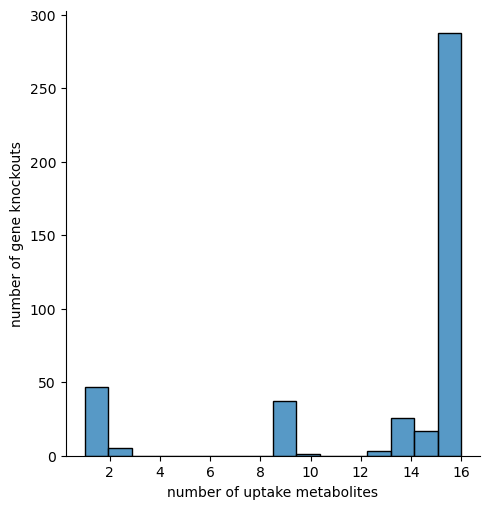

In [102]:
sns.displot(gene_uptake_knockout_df.groupby('gid').size(), bins=16)
plt.xlabel('number of uptake metabolites')
plt.ylabel('number of gene knockouts')


In [103]:
sns.displot(reaction_uptake_knockout_df.groupby('rid').size(), bins=16)
plt.xlabel('number of uptake metabolites')
plt.ylabel('number of reaction knockouts')


Text(13.819444444444445, 0.5, 'number of reaction knockouts')

In [104]:
gene_uptake_knockout_df.columns

Index(['Unnamed: 0', 'ids', 'growth', 'status', 'uptake', 'secretion', 'gid',
       'knockout', 'rid', 'reaction', 'gene_id', 'pmm', 'gene', 'product',
       'status_de', 'sub', 'path', 'ecpath', 'baseMean', 'log2FoldChange',
       'padj'],
      dtype='object')

In [105]:
gene_uptake_knockout_df['knockout'].value_counts()

gene        5648
reaction      18
Name: knockout, dtype: int64

In [106]:
gpdf = gene_uptake_knockout_df.pivot_table(index='gene',columns='uptake', values='log2FoldChange', aggfunc='mean',
                                           fill_value=0)


In [107]:
gene_uptake_knockout_df['stars'] = ''
gene_uptake_knockout_df.loc[gene_uptake_knockout_df.padj < 0.1, 'stars'] = '*'
gene_uptake_knockout_df.loc[gene_uptake_knockout_df.padj < 0.05, 'stars'] = '**'
gene_uptake_knockout_df.loc[gene_uptake_knockout_df.padj < 0.01, 'stars'] = '***'


In [108]:
gene_uptake_knockout_df.groupby( ['gene','uptake'] ).size().reset_index().nlargest(columns=0, n=20)


,gene,uptake,0
3339,cysK,AmmoniaEX,2
3340,cysK,CyanateEX,2
3341,cysK,GlutathioneEX,2
3342,cysK,GlycineEX,2
3343,cysK,GuanineEX,2
3344,cysK,GuanosineEX,2
3345,cysK,L_AlanineEX,2
3346,cysK,L_ArginineEX,2
3347,cysK,L_AspartateEX,2
3348,cysK,L_CystineEX,2


In [109]:
gpdf_padj = gene_uptake_knockout_df.pivot_table(index='gene',columns='uptake', values='stars', aggfunc='first',
                                           fill_value='')


In [110]:
gene_uptake_knockout_df.head()

,Unnamed: 0,ids,growth,status,uptake,secretion,gid,knockout,rid,reaction,...,gene,product,status_de,sub,path,ecpath,baseMean,log2FoldChange,padj,stars
0,0,{'PMM0951'},NaN,infeasible,L_GlutamateEX,NaN,PMM0951,gene,NaN,NaN,...,carA,glutamine-hydrolyzing carbamoyl-phosphate synt...,down,09104 Nucleotide metabolism // 09105 Amino aci...,00240 Pyrimidine metabolism [PATH:ko00240] // ...,"K01956 carA, CPA1; carbamoyl-phosphate syntha...",178.513724,-1.504660,1.544491e-08,***
1,1,{'PMM0796'},NaN,infeasible,L_GlutamateEX,NaN,PMM0796,gene,NaN,NaN,...,hisA,1-(5-phosphoribosyl)-5-[(5-phosphoribosylamino...,no_significant,09105 Amino acid metabolism,00340 Histidine metabolism [PATH:ko00340],K01814 hisA; phosphoribosylformimino-5-aminoi...,284.786091,0.285050,2.226182e-01,
2,3,{'PMM0483'},NaN,infeasible,L_GlutamateEX,NaN,PMM0483,gene,NaN,NaN,...,hemL,"glutamate-1-semialdehyde 2,1-aminomutase",no_significant,09108 Metabolism of cofactors and vitamins // ...,00860 Porphyrin metabolism [PATH:ko00860] // 0...,"K01845 hemL; glutamate-1-semialdehyde 2,1-ami...",2468.751490,0.459796,1.200598e-01,
3,5,{'PMM0001'},0.00001,optimal,L_GlutamateEX,NaN,PMM0001,gene,NaN,NaN,...,dnaN,DNA polymerase III subunit beta,no_significant,09124 Replication and repair // 09182 Protein ...,03030 DNA replication [PATH:ko03030] // 03430 ...,K02338 dnaN; DNA polymerase III subunit beta ...,1548.906501,0.228545,4.619685e-01,
4,7,{'PMM1181'},NaN,infeasible,L_GlutamateEX,NaN,PMM1181,gene,NaN,NaN,...,aroH,chorismate mutase,down,09105 Amino acid metabolism,"00400 Phenylalanine, tyrosine and tryptophan b...",K06208 aroH; chorismate mutase [EC:5.4.99.5],195.838847,-1.247608,8.508785e-09,***


In [111]:
gene_uptake_knockout_df['sub'].drop_duplicates().str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

09105 Amino acid metabolism                                 33
09181 Protein families: metabolism                          32
09101 Carbohydrate metabolism                               27
09102 Energy metabolism                                     22
09183 Protein families: signaling and cellular processes    21
09108 Metabolism of cofactors and vitamins                  20
09104 Nucleotide metabolism                                 18
09106 Metabolism of other amino acids                       15
09103 Lipid metabolism                                      12
09107 Glycan biosynthesis and metabolism                    10
09110 Biosynthesis of other secondary metabolites           10
09132 Signal transduction                                   10
09182 Protein families: genetic information processing       9
09175 Drug resistance: antimicrobial                         6
09111 Xenobiotics biodegradation and metabolism              6
09109 Metabolism of terpenoids and polyketides         

In [112]:
gene_uptake_knockout_df['sub'].str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

09108 Metabolism of cofactors and vitamins                  1509
09105 Amino acid metabolism                                 1279
09181 Protein families: metabolism                          1140
09102 Energy metabolism                                      964
09101 Carbohydrate metabolism                                646
09104 Nucleotide metabolism                                  642
09183 Protein families: signaling and cellular processes     627
09182 Protein families: genetic information processing       415
09103 Lipid metabolism                                       336
09106 Metabolism of other amino acids                        300
09107 Glycan biosynthesis and metabolism                     289
09110 Biosynthesis of other secondary metabolites            286
09109 Metabolism of terpenoids and polyketides               282
09131 Membrane transport                                     232
09124 Replication and repair                                 192
09132 Signal transduction

In [113]:
kegg_categories_map = {
    '09183 Protein families: signaling and cellular processes' : 'Signal/cellular',
    '09132 Signal transduction' : 'Signal/cellular',                                
    '09193 Unclassified: signaling and cellular processes' : 'Signal/cellular',
    '09143 Cell growth and death' : 'Signal/cellular',                              
    #'09132 Signal transduction': 'Signal transduction',
    '09109 Metabolism of terpenoids and polyketides' : 'Secondary',
    '09182 Protein families: genetic information processing' : 'genetic info',
    '09110 Biosynthesis of other secondary metabolites' : 'Secondary', 
    '09108 Metabolism of cofactors and vitamins': 'Secondary',
    '09102 Energy metabolism' : 'Energy',
    '09101 Carbohydrate metabolism': 'Carbohydrate',
    '09104 Nucleotide metabolism' : 'Nucleotide',
    '09105 Amino acid metabolism' : 'Amino acid',
    '09106 Metabolism of other amino acids' : 'Amino acid',
    #'09143 Cell growth and death', 'Cell growth and death',
    #'09123 Folding, sorting and degradation' : 'Folding'
    #'09141 Transport and catabolism' : ''
#09124 Replication and repair                                 12
    #'09131 Membrane transport' : 'Membrane transport',
    '09103 Lipid metabolism' : 'Lipid',
    '09107 Glycan biosynthesis and metabolism' : 'Glycan',
}


In [114]:
deseq_df.columns

Index(['gene_id', 'gene', 'product', 'status', 'main', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'contrast', 'Length', 'organism', 'protein_id'],
      dtype='object')

In [115]:
kegg_rowanno = deseq_df[['sub', 'log2FoldChange']]
kegg_rowanno.index= deseq_df['gene']
kegg_rowanno = kegg_rowanno[~kegg_rowanno.index.duplicated(keep='first')]
kegg_rowanno = kegg_rowanno.loc[gpdf.index,:]
#kegg_rowanno = kegg_rowanno.to_frame(name='cat')

In [116]:
kegg_rowanno.columns

Index(['sub', 'log2FoldChange'], dtype='object')


for i, j in kegg_categories_map.items():
    kegg_rowanno[j] = kegg_rowanno.cat.str.contains(i)

In [117]:
kegg_rowanno['sub'] = kegg_rowanno['sub'].fillna('')
for i, j in kegg_categories_map.items():
    kegg_rowanno.loc[kegg_rowanno['sub'].str.contains(i), 'Category']  = j
kegg_rowanno.loc[kegg_rowanno['Category'].isna(), 'Category']  = 'Other'
    

In [118]:
kegg_rowanno.Category.value_counts()

Amino acid         90
Secondary          88
Energy             67
Signal/cellular    33
Other              32
Nucleotide         31
Carbohydrate       23
Lipid              21
genetic info       19
Glycan             19
Name: Category, dtype: int64

In [119]:
kegg_rowanno.loc[kegg_rowanno.Category.isin(['Other']), 'sub'].str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

                                      24
09191 Unclassified: metabolism         6
09194 Poorly characterized             1
09181 Protein families: metabolism     1
Name: value, dtype: int64

In [120]:
kegg_rowanno_sorted = kegg_rowanno.sort_values(by=['Category', 'log2FoldChange' ], ascending=[True, False])

In [121]:
gpdf_sorted = gpdf.reindex(kegg_rowanno_sorted.index)
gpdf_padj_sorted = gpdf_padj.reindex(kegg_rowanno_sorted.index)


In [122]:
cl_labels = kegg_rowanno.Category.unique()
cl_labels.sort()

lut = dict(zip(cl_labels, sns.color_palette(palette='Set3', n_colors=len(cl_labels))))
row_anno = kegg_rowanno_sorted.Category.map(lut)

In [123]:
from matplotlib.patches import Patch
#sel = ((gpdf_sorted != 0).sum(axis=1) >8) & ((gpdf != 0).sum(axis=1) < gpdf.shape[1])
sel = ((gpdf_sorted != 0).sum(axis=1) < gpdf_sorted.shape[1])
sns.clustermap(data=gpdf_sorted.loc[sel], 
               mask=(gpdf_sorted.loc[sel] == 0),
               #annot=gpdf_padj_sorted.loc[sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(5,10), lw=0.001, cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
               yticklabels=False,
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 uptake gene knockouts', y=1)

Text(0.5, 1, 'med4 uptake gene knockouts')

In [124]:
from matplotlib.patches import Patch
sel = (gpdf_sorted != 0).sum(axis=1) <=8
col_sel = (gpdf_sorted.loc[sel] != 0).sum(axis=0) != 0
sns.clustermap(data=gpdf_sorted.loc[sel, col_sel], 
               mask=(gpdf_sorted.loc[sel, col_sel] == 0),
               annot=gpdf_padj_sorted.loc[sel, col_sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(5,10), lw=0.01, cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 uptake gene knockouts', y=1)

Text(0.5, 1, 'med4 uptake gene knockouts')

In [125]:
from matplotlib.patches import Patch
sel = (gpdf_sorted != 0).sum(axis=1) <=8
col_sel = (gpdf_sorted.loc[sel] != 0).sum(axis=0) != 0
sns.clustermap(data=gpdf_sorted.loc[sel, col_sel], 
               mask=(gpdf_sorted.loc[sel, col_sel] == 0),
               annot=gpdf_padj_sorted.loc[sel, col_sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(5,10), lw=0.01, cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               #row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 uptake gene knockouts', y=1)

Text(0.5, 1, 'med4 uptake gene knockouts')

In [126]:
sel = rpdf.sum(axis=1)< 14
sns.set_context('paper')
sns.clustermap(data=rpdf.loc[sel], 
               yticklabels= rpdf.loc[sel].index.str.slice(0, 20),
               figsize=(5,10), lw=0.01,
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               cbar_pos=(1, .2, .01, .4),
#                 #cmap='coolwarm',
#                row_cluster=False,
              )




plt.suptitle('med4 uptake reaction knockouts', y=1)

Text(0.5, 1, 'med4 uptake reaction knockouts')

In [127]:
sel = rpdf.sum(axis=1)< 16
sns.set_context('paper')
sns.clustermap(data=rpdf.loc[sel], 
               yticklabels= rpdf.loc[sel].index.str.slice(0, 35),
               figsize=(7,12), lw=0.01,
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               cbar_pos=(1, .2, .01, .4),
#                 #cmap='coolwarm',
#                row_cluster=False,
              )




plt.suptitle('med4 uptake reaction knockouts', y=1)

Text(0.5, 1, 'med4 uptake reaction knockouts')

# Secretion visualization

In [128]:
gene_secretion_knockout_nodup_df.columns

Index(['Unnamed: 0', 'ids', 'growth', 'status', 'uptake', 'secretion', 'gid',
       'knockout', 'rid', 'reaction', 'gene_id', 'pmm', 'gene', 'product',
       'status_de', 'sub', 'path', 'ecpath', 'baseMean', 'log2FoldChange',
       'padj'],
      dtype='object')

In [129]:
sgpdf = gene_secretion_knockout_nodup_df.pivot_table(index='gene',columns='secretion', values='log2FoldChange', aggfunc='mean',
                                           fill_value=0)


In [130]:
srpdf = reaction_secretion_knockout_nodup_df.loc[
    ~reaction_secretion_knockout_nodup_df.rid.isin(exchange_ids)
].pivot_table(index='reaction',columns='secretion', values='status', aggfunc='count', fill_value=0)

In [131]:
sns.displot(gene_secretion_knockout_nodup_df.groupby('gid').size(), bins=16)
plt.xlabel('number of secretion metabolites')
plt.ylabel('number of gene knockouts')


Text(4.96944444444445, 0.5, 'number of gene knockouts')

In [132]:
sns.displot(reaction_secretion_knockout_nodup_df.groupby('rid').size(), bins=16)
plt.xlabel('number of secretion metabolites')
plt.ylabel('number of reaction knockouts')


Text(4.96944444444445, 0.5, 'number of reaction knockouts')

In [133]:
gene_secretion_knockout_nodup_df['knockout'].value_counts()

gene        641
reaction    248
Name: knockout, dtype: int64

In [134]:
gene_secretion_knockout_nodup_df['stars'] = ''
gene_secretion_knockout_nodup_df.loc[gene_secretion_knockout_nodup_df.padj < 0.1, 'stars'] = '*'
gene_secretion_knockout_nodup_df.loc[gene_secretion_knockout_nodup_df.padj < 0.05, 'stars'] = '**'
gene_secretion_knockout_nodup_df.loc[gene_secretion_knockout_nodup_df.padj < 0.01, 'stars'] = '***'


In [135]:
gene_secretion_knockout_nodup_df.groupby( ['gene','secretion'] ).size().reset_index().nlargest(columns=0, n=20)


,gene,secretion,0
668,lipA,L_IsoleucineEX,2
0,TX50_RS00370,4_Methyl_2_oxopentanoateEX,1
1,TX50_RS00370,5_MethylthioadenosineEX,1
2,TX50_RS00370,ThiosulfateEX,1
3,TX50_RS00510,5_MethylthioadenosineEX,1
4,TX50_RS00655,BiotinEX,1
5,TX50_RS00655,EthanolEX,1
6,TX50_RS00655,L_CystineEX,1
7,TX50_RS00740,5_MethylthioadenosineEX,1
8,TX50_RS00740,L_LeucineEX,1


In [136]:
sgpdf_padj = gene_secretion_knockout_nodup_df.pivot_table(index='gene',columns='secretion', values='stars', aggfunc='first',
                                           fill_value='')


In [137]:
gene_secretion_knockout_nodup_df['sub'].drop_duplicates().str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

09101 Carbohydrate metabolism                               16
09182 Protein families: genetic information processing      15
09102 Energy metabolism                                     12
09181 Protein families: metabolism                          10
09183 Protein families: signaling and cellular processes     9
09108 Metabolism of cofactors and vitamins                   9
09105 Amino acid metabolism                                  8
09106 Metabolism of other amino acids                        7
09145 Cellular community - prokaryotes                       5
09152 Endocrine system                                       5
09104 Nucleotide metabolism                                  5
09122 Translation                                            4
09109 Metabolism of terpenoids and polyketides               4
09159 Environmental adaptation                               3
09132 Signal transduction                                    3
09110 Biosynthesis of other secondary metabolites      

In [138]:
gene_secretion_knockout_nodup_df['sub'].str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

09101 Carbohydrate metabolism                               282
09102 Energy metabolism                                     186
09105 Amino acid metabolism                                 137
09183 Protein families: signaling and cellular processes    128
09182 Protein families: genetic information processing      106
09145 Cellular community - prokaryotes                      104
09181 Protein families: metabolism                          104
09106 Metabolism of other amino acids                        94
09108 Metabolism of cofactors and vitamins                   89
09191 Unclassified: metabolism                               48
09104 Nucleotide metabolism                                  40
09122 Translation                                            37
09131 Membrane transport                                     31
09161 Cancer: overview                                       29
09166 Cardiovascular disease                                 27
09132 Signal transduction               

In [139]:
kegg_categories_map = {
    '09183 Protein families: signaling and cellular processes' : 'Signal/cellular',
    '09132 Signal transduction' : 'Signal/cellular',                                
    '09193 Unclassified: signaling and cellular processes' : 'Signal/cellular',
    '09143 Cell growth and death' : 'Signal/cellular',                              
    #'09132 Signal transduction': 'Signal transduction',
    '09109 Metabolism of terpenoids and polyketides' : 'Secondary',
    '09182 Protein families: genetic information processing' : 'genetic info',
    '09110 Biosynthesis of other secondary metabolites' : 'Secondary', 
    '09108 Metabolism of cofactors and vitamins': 'Secondary',
    '09102 Energy metabolism' : 'Energy',
    '09101 Carbohydrate metabolism': 'Carbohydrate',
    '09104 Nucleotide metabolism' : 'Nucleotide',
    '09105 Amino acid metabolism' : 'Amino acid',
    '09106 Metabolism of other amino acids' : 'Amino acid',
    #'09143 Cell growth and death', 'Cell growth and death',
    #'09123 Folding, sorting and degradation' : 'Folding'
    #'09141 Transport and catabolism' : ''
#09124 Replication and repair                                 12
    #'09131 Membrane transport' : 'Membrane transport',
    '09103 Lipid metabolism' : 'Lipid',
    '09107 Glycan biosynthesis and metabolism' : 'Glycan',
}


In [140]:
deseq_df.columns

Index(['gene_id', 'gene', 'product', 'status', 'main', 'sub', 'path', 'ecpath',
       'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj',
       'contrast', 'Length', 'organism', 'protein_id'],
      dtype='object')

In [141]:
skegg_rowanno = deseq_df[['sub', 'log2FoldChange']]
skegg_rowanno.index= deseq_df['gene']
skegg_rowanno = skegg_rowanno[~skegg_rowanno.index.duplicated(keep='first')]
skegg_rowanno = skegg_rowanno.loc[sgpdf.index,:]
#kegg_rowanno = kegg_rowanno.to_frame(name='cat')

In [142]:
skegg_rowanno.columns

Index(['sub', 'log2FoldChange'], dtype='object')


for i, j in kegg_categories_map.items():
    kegg_rowanno[j] = kegg_rowanno.cat.str.contains(i)

In [143]:
skegg_rowanno['sub'] = skegg_rowanno['sub'].fillna('')
for i, j in kegg_categories_map.items():
    skegg_rowanno.loc[skegg_rowanno['sub'].str.contains(i), 'Category']  = j
skegg_rowanno.loc[skegg_rowanno['Category'].isna(), 'Category']  = 'Other'
    

In [144]:
skegg_rowanno.Category.value_counts()

Other              28
Secondary          24
Amino acid         22
genetic info       22
Carbohydrate       21
Signal/cellular    11
Energy             10
Nucleotide          8
Glycan              5
Lipid               3
Name: Category, dtype: int64

In [145]:
skegg_rowanno.loc[skegg_rowanno.Category.isin(['Other']), 'sub'].str.split(' // ', 
                                         expand=True).melt().dropna()['value'].value_counts()

                                          18
09191 Unclassified: metabolism             9
09123 Folding, sorting and degradation     1
Name: value, dtype: int64

In [146]:
skegg_rowanno_sorted = skegg_rowanno.sort_values(by=['Category', 'log2FoldChange' ], ascending=[True, False])

In [147]:
sgpdf_sorted = sgpdf.reindex(skegg_rowanno_sorted.index)
sgpdf_padj_sorted = sgpdf_padj.reindex(skegg_rowanno_sorted.index)


In [148]:
cl_labels = skegg_rowanno.Category.unique()
cl_labels.sort()

lut = dict(zip(cl_labels, sns.color_palette(palette='Set3', n_colors=len(cl_labels))))
row_anno = skegg_rowanno_sorted.Category.map(lut)

In [149]:
from matplotlib.patches import Patch
#sel = ((sgpdf_sorted != 0).sum(axis=1) >8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
sel = ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
g = sns.clustermap(data=sgpdf_sorted.loc[sel], 
               mask=(sgpdf_sorted.loc[sel] == 0),
               #annot=gpdf_padj_sorted.loc[sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(15,10), lw=0.001, cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               #dendrogram_ratio=0.01,
               linecolor='lightgrey',
               row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
               yticklabels=False,
               xticklabels= sgpdf_sorted.loc[sel].columns.str.slice(0, 20),
               
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 secretion gene knockouts', y=1)

Text(0.5, 1, 'med4 secretion gene knockouts')

In [150]:
from sklearn.cluster import AgglomerativeClustering
sel = ((sgpdf_sorted != 0).sum(axis=1) <=8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])

clustering_model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
clustering_model.fit(sgpdf_sorted.loc[sel].T == 0)
clustering_model.labels_

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [151]:
from matplotlib.patches import Patch
for i in range(2):
    
    col_sel = clustering_model.labels_ == i
    sel = ((sgpdf_sorted != 0).sum(axis=1) <=8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
    #sel = ((sgpdf_sorted != 0).sum(axis=1) >8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
    #sel = ((sgpdf_sorted.loc[:,col_sel] != 0).sum(axis=1) < sgpdf_sorted.shape[1])
    #sel = ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
    g = sns.clustermap(data=sgpdf_sorted.loc[sel,col_sel], 
                   mask=(sgpdf_sorted.loc[sel,col_sel] == 0),
                   #annot=gpdf_padj_sorted.loc[sel], fmt='',
                   row_colors=row_anno.loc[sel],
                   figsize=(10,10), lw=0.001, cmap='coolwarm', center=0,
                  colors_ratio=0.04, 
                   #dendrogram_ratio=0.01,
                   linecolor='lightgrey',
                   row_cluster=False,
                   cbar_pos=(1, .2, .01, .4),
                   yticklabels=False,
                   xticklabels= sgpdf_sorted.loc[sel].columns.str.slice(0, 20),

                  )

    handles = [Patch(facecolor=lut[name]) for name in lut]
    plt.legend(handles, lut, title='Category',
               bbox_to_anchor=(1.1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    plt.suptitle('med4 secretion gene knockouts', y=1)

In [152]:
skegg_rowanno_sorted

,sub,log2FoldChange,Category
gene,,,
mtnP,09105 Amino acid metabolism,0.839025,Amino acid
argJ,09105 Amino acid metabolism,0.790923,Amino acid
cysE,09102 Energy metabolism // 09105 Amino acid me...,0.687886,Amino acid
TX50_RS00370,09106 Metabolism of other amino acids,0.294328,Amino acid
TX50_RS03145,09105 Amino acid metabolism // 09110 Biosynthe...,0.258452,Amino acid
...,...,...,...
serS,09122 Translation // 09181 Protein families: m...,-0.524039,genetic info
TX50_RS08230,09121 Transcription // 09182 Protein families:...,-0.565906,genetic info
trpS,09122 Translation // 09181 Protein families: m...,-0.592245,genetic info


In [153]:
from matplotlib.patches import Patch
#sel = ((sgpdf_sorted != 0).sum(axis=1) >8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
for cat in cl_labels:
    sel = ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
    row_sel = skegg_rowanno_sorted.Category.isin([cat])
sel, row_sel


(gene
 mtnP            True
 argJ            True
 cysE            True
 TX50_RS00370    True
 TX50_RS03145    True
                 ... 
 serS            True
 TX50_RS08230    True
 trpS            True
 leuS            True
 glyS            True
 Length: 154, dtype: bool,
 gene
 mtnP            False
 argJ            False
 cysE            False
 TX50_RS00370    False
 TX50_RS03145    False
                 ...  
 serS             True
 TX50_RS08230     True
 trpS             True
 leuS             True
 glyS             True
 Name: Category, Length: 154, dtype: bool)

In [154]:
vmin = sgpdf_sorted.min().min()
vmax = sgpdf_sorted.max().max()
vmin, vmax

(-3.0108353196405595, 1.8419680121935724)

In [155]:
from matplotlib.patches import Patch
#sel = ((sgpdf_sorted != 0).sum(axis=1) >8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
vmin = sgpdf_sorted.min().min()
vmax = sgpdf_sorted.max().max()

for cat in cl_labels:
    sel = ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1]) &((sgpdf_sorted != 0).sum(axis=1) <=8) & skegg_rowanno_sorted.Category.isin([cat])
    col_sel = (sgpdf_sorted.loc[sel] != 0).sum(axis=0) > 0
    number_of_cols = col_sel.sum()
    total_number_of_cols = sgpdf_sorted.shape[1]
    number_of_rows = sel.sum()
    total_number_of_rows = sgpdf_sorted.shape[0]
    width = number_of_cols / total_number_of_cols
    height = number_of_rows / total_number_of_rows
    if (height/width < 0.2):
        height = width*0.2
    g = sns.clustermap(data=sgpdf_sorted.loc[sel, col_sel], 
                   mask=(sgpdf_sorted.loc[sel, col_sel] == 0),
                   annot=sgpdf_padj_sorted.loc[sel, col_sel], fmt='',
                   row_colors=row_anno.loc[sel],
                   figsize=(15*width,40*height), lw=0.01, cmap='coolwarm', center=0,
                   vmin=vmin, vmax=vmax,
                   
                   colors_ratio=0.04, 
                   dendrogram_ratio=0.01,
                   linecolor='lightgrey',
                   row_cluster=False,
                   cbar_pos=(1, .2, .01, .4),
                   #yticklabels=False,
                   xticklabels= sgpdf_sorted.loc[sel, col_sel].columns.str.slice(0, 20),
                       
                  )
    g.cax.set_visible(False)
    print(cat, width, height, height/width)

# handles = [Patch(facecolor=lut[name]) for name in lut]
# plt.legend(handles, lut, title='Category',
#            bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    plt.suptitle(f'med4 secretion gene knockouts - {cat}', y=1)

Amino acid 0.48214285714285715 0.11038961038961038 0.22895622895622894
Carbohydrate 0.375 0.09740259740259741 0.25974025974025977


/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Energy 0.19642857142857142 0.039285714285714285 0.2


/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Glycan 0.14285714285714285 0.032467532467532464 0.22727272727272727


/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Lipid 0.10714285714285714 0.02142857142857143 0.2


/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Nucleotide 0.14285714285714285 0.03896103896103896 0.27272727272727276
Other 0.39285714285714285 0.14285714285714285 0.36363636363636365
Secondary 0.42857142857142855 0.15584415584415584 0.36363636363636365
Signal/cellular 0.375 0.07500000000000001 0.20000000000000004


/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


genetic info 0.26785714285714285 0.14285714285714285 0.5333333333333333


In [156]:
from matplotlib.patches import Patch
#sel = ((sgpdf_sorted != 0).sum(axis=1) >8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
vmin = sgpdf_sorted.min().min()
vmax = sgpdf_sorted.max().max()

for cat in cl_labels:
    sel = ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])  & skegg_rowanno_sorted.Category.isin([cat])
    col_sel = (sgpdf_sorted.loc[sel] != 0).sum(axis=0) > 0
    number_of_cols = col_sel.sum()
    total_number_of_cols = sgpdf_sorted.shape[1]
    number_of_rows = sel.sum()
    total_number_of_rows = sgpdf_sorted.shape[0]
    width = number_of_cols / total_number_of_cols
    height = number_of_rows / total_number_of_rows
    if (height/width < 0.2):
        height = width*0.2
    g = sns.clustermap(data=sgpdf_sorted.loc[sel, col_sel], 
                   mask=(sgpdf_sorted.loc[sel, col_sel] == 0),
                   annot=sgpdf_padj_sorted.loc[sel, col_sel], fmt='',
                   row_colors=row_anno.loc[sel],
                   figsize=(15*width,40*height), lw=0.01, cmap='coolwarm', center=0,
                   vmin=vmin, vmax=vmax,
                   
                   colors_ratio=0.04, 
                   dendrogram_ratio=0.01,
                   linecolor='lightgrey',
                   row_cluster=False,
                   cbar_pos=(1, .2, .01, .4),
                   #yticklabels=False,
                   xticklabels= sgpdf_sorted.loc[sel, col_sel].columns.str.slice(0, 20),
                       
                  )
    g.cax.set_visible(False)
    print(cat, width, height, height/width)

# handles = [Patch(facecolor=lut[name]) for name in lut]
# plt.legend(handles, lut, title='Category',
#            bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

    plt.suptitle(f'med4 secretion gene knockouts - {cat}', y=1)

Amino acid 1.0 0.2 0.2
Carbohydrate 0.9642857142857143 0.19285714285714287 0.2
Energy 0.4107142857142857 0.08214285714285714 0.2


/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Glycan 0.14285714285714285 0.032467532467532464 0.22727272727272727


/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:1203: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


Lipid 0.10714285714285714 0.02142857142857143 0.2
Nucleotide 0.4107142857142857 0.08214285714285714 0.2
Other 1.0 0.2 0.2
Secondary 0.42857142857142855 0.15584415584415584 0.36363636363636365
Signal/cellular 0.375 0.07500000000000001 0.20000000000000004
genetic info 0.26785714285714285 0.14285714285714285 0.5333333333333333


In [157]:
from matplotlib.patches import Patch
#sel = ((sgpdf_sorted != 0).sum(axis=1) >8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
sel = ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
sns.clustermap(data=sgpdf_sorted.loc[sel], 
               mask=(sgpdf_sorted.loc[sel] == 0),
               #annot=gpdf_padj_sorted.loc[sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(15,10), lw=0.001, cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               #row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
               yticklabels=False,
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 secretion gene knockouts', y=1)

Text(0.5, 1, 'med4 secretion gene knockouts')

In [158]:
from matplotlib.patches import Patch
#sel = ((sgpdf_sorted != 0).sum(axis=1) >8) & ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
sel = ((sgpdf_sorted != 0).sum(axis=1) < sgpdf_sorted.shape[1])
sns.clustermap(data=sgpdf_sorted.loc[sel], 
               mask=(sgpdf_sorted.loc[sel] == 0),
               #annot=gpdf_padj_sorted.loc[sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(15,10), lw=0.001, cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               dendrogram_ratio=0.01,
               linecolor='lightgrey',
               row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
               yticklabels=False,
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 secretion gene knockouts', y=1)

Text(0.5, 1, 'med4 secretion gene knockouts')

In [159]:
from matplotlib.patches import Patch
sel = (sgpdf_sorted != 0).sum(axis=1) <=5
col_sel = (sgpdf_sorted.loc[sel] != 0).sum(axis=0) != 0
sns.clustermap(data=sgpdf_sorted.loc[sel, col_sel], 
               mask=(sgpdf_sorted.loc[sel, col_sel] == 0),
               annot=sgpdf_padj_sorted.loc[sel, col_sel], fmt='',
               row_colors=row_anno.loc[sel],
               figsize=(15,10), #lw=0.01,
               cmap='coolwarm', center=0,
              colors_ratio=0.04, 
               dendrogram_ratio=0.01,
               #linecolor='lightgrey',
               row_cluster=False,
               cbar_pos=(1, .2, .01, .4),
              )

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Category',
           bbox_to_anchor=(1.3, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

plt.suptitle('med4 secretion gene knockouts', y=1)

Text(0.5, 1, 'med4 secretion gene knockouts')

In [160]:
g_uptake = set(gene_uptake_knockout_df.gid.unique())
g_sec = set(gene_secretion_knockout_df.gid.unique())
g2_sec = set(gene_secretion_knockout_nodup_df.gid.unique())


In [161]:
g2_sec & g_uptake

set()

In [162]:
len(g_uptake) , len(g_sec), len(g2_sec), sgpdf.shape

(424, 106, 155, (154, 56))

In [163]:
sel = srpdf.sum(axis=1)>0
sns.set_context('paper')
sns.clustermap(data=srpdf.loc[sel], 
               yticklabels= srpdf.loc[sel].index.str.slice(0, 20),
               #yticklabels= None,
               figsize=(15,10), #lw=0.01,
               dendrogram_ratio=0.01,
               #linecolor='lightgrey',
               cbar_pos=(1, .2, .01, .4),
#                 #cmap='coolwarm',
#                row_cluster=False,
              )




plt.suptitle('med4 uptake reaction knockouts', y=1)

/home/oweissberg/work/tools/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1, 'med4 uptake reaction knockouts')

In [164]:
from openpyxl import load_workbook

fpath = 'data/PRO_N_sources.xlsx'

book = load_workbook(fpath)
writer = pd.ExcelWriter(fpath, engine = 'openpyxl')
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

gene_uptake_knockout_df.to_excel(writer, sheet_name = 'gene_knockout_uptake')
reaction_uptake_knockout_df.to_excel(writer, sheet_name = 'reactin_knockout_uptake')
#writer.save()
writer.close()

In [165]:
n_exchange_df.head()                          

,Unnamed: 0,secretion,minimum,maximum,uptake,metabolite_uptake,mid_uptake,N_uptake,C_uptake,metabolite_secretion,mid_secretion,N_secretion,C_secretion
0,0,B12EX,0.000000,7.941910,GuanosineEX,Guanosine[e],Guanosine[e],True,True,Cobamide coenzyme,Cobamide_coenzyme[e],True,True
1,1,BiotinEX,0.000000,1.985477,GuanosineEX,Guanosine[e],Guanosine[e],True,True,Biotin,Biotin[e],True,True
2,2,MethanolEX,0.000042,1.985519,GuanosineEX,Guanosine[e],Guanosine[e],True,True,Methanol,Methanol[e],False,True
3,3,SAdenosyl4methylthio2oxobutanoateEX,0.000042,1.985519,GuanosineEX,Guanosine[e],Guanosine[e],True,True,S-Adenosyl-4-methylthio-2-oxobutanoate,S_Adenosyl_4_methylthio_2_oxobutanoate[e],True,True
4,4,SMethyl5thioDriboseEX,0.000000,15.884229,GuanosineEX,Guanosine[e],Guanosine[e],True,True,S-Methyl-5-thio-D-ribose,S_Methyl_5_thio_D_ribose[e],False,True


In [166]:
n_exchange_df.shape

(881, 13)